### Описание задачи

В некой стране Компания производит различные товары-сладости (SKU) и осуществляет продажу в 4х туристических городах (локациях), где количество и тип потребителей меняется от месяца к месяцу. Основную часть ассортимента Компании составляет шоколад, а основной объем продаж приходится на город Alpha City.

Компании доступно 2 источника информации, оба помесячные: внутренние данные по отгрузкам и розничным ценам в каждом из 4х городов, а также внешние данные, которые компания закупает у стороннего подрядчика, по количеству и типам клиентов в городах. 

Данные по продажам - sales.tsv  
Данные по потоку потребителей - customers.tsv

 - sku_id = уникальный идентификатор одной позиции товара (SKU = Stock Keeping Unit).  
 - ira = International Retail Association  = уникальный код локации согласно классификации международной ассоциации ретейлеров.  
 - product_category – категория продукта.  
 - item_per_bundle – количество единиц товара на 1 упаковку (например, бывают наборы по 3 шоколадки сразу).  
 - shape – форма упаковки.  
 - with_alcohol – содержит ли алкоголь в начинке (yes/no).  
 - filling – начинка.  
 - volume – объем продаж в штуках.  
 - price – цена 1 штуку товара в USD.  

Данные по типу и количеству клиентов (потоку клиентов), имеет глубокую экспертизу и дополнительные внешние источники (например, забронированные путевки), на основании которых предоставляет как фактические данные (до июня 2019 года включительно), так и достаточно точной прогноз на 3 месяца вперед (июль-сентября 2019)

Сейчас 01 июля 2019 года, Компания только что получила свежие данные по продажам до июня включительно. Вас, как специалиста по продвинутой аналитике, наняли для того, чтобы найти алгоритм, максимально точно описывающий поведение рынка, то есть зависимость продаж каждой позиции товара в каждой локации от различных факторов. 

## Задача 1

Сейчас 01 июля 2019 года, нужно спрогнозировать продажи по каждому SKU в ассортименте для каждой локации на 3 месяца вперед помесячно (июль, август, сентябрь) с предположением, что цены останутся неизменными по сравнению с последним месяцем.Точность оценивается по метрике SMAPE.  
Если для какого-то SKU в какой-то локации прогноз сделать невозможно, необходимо указать причину.

In [202]:
#pip install -r requirements.txt

In [203]:
#pip install statsmodels

In [204]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [205]:
%matplotlib inline

In [206]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Загрузка данных

In [207]:
df_sales = pd.read_csv("data/sales.tsv", sep='\t')

In [208]:
df_custs= pd.read_csv("data/customers.tsv", sep='\t')

In [209]:
df_sales.head()

year  month    location ira product_category           brand   sku_id  \
0  2017      1  Alpha City  AC       Chocolates         Cadbury  sku #79   
1  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #15   
2  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #16   
3  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #22   
4  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #28   

   item_per_bundle     shape with_alcohol  filling   volume     price  
0                1  Standart           No  Nothing   4572.0       NaN  
1                1  Standart           No  Nothing   8028.0  1.221336  
2                3  Standart           No  Nothing   6606.0  2.866401  
3                2  Standart           No  Nothing  11688.0  2.093719  
4                3  Standart           No  Nothing   3582.0  2.866401

In [210]:
df_custs.head()

year  month ira customers_type  amount_of_customers
0  2017      1  AC         Archer                679.0
1  2017      1  AC           Monk               1070.0
2  2017      1  AC          Dwarf                610.0
3  2017      1  AC        Centaur               1315.0
4  2017      1  AC        Gremlin               1554.0

#### Работа с пропусками значений

In [211]:
df_custs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 1980 non-null   int64  
 1   month                1980 non-null   int64  
 2   ira                  1980 non-null   object 
 3   customers_type       1980 non-null   object 
 4   amount_of_customers  1980 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 77.5+ KB


In [212]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              1729 non-null   int64  
 1   month             1729 non-null   int64  
 2   location          1729 non-null   object 
 3   ira               1729 non-null   object 
 4   product_category  1729 non-null   object 
 5   brand             1729 non-null   object 
 6   sku_id            1729 non-null   object 
 7   item_per_bundle   1729 non-null   int64  
 8   shape             1729 non-null   object 
 9   with_alcohol      1729 non-null   object 
 10  filling           1729 non-null   object 
 11  volume            1729 non-null   float64
 12  price             1617 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 175.7+ KB


In [213]:
df_sales.isnull().sum()

year                  0
month                 0
location              0
ira                   0
product_category      0
brand                 0
sku_id                0
item_per_bundle       0
shape                 0
with_alcohol          0
filling               0
volume                0
price               112
dtype: int64

 Есть пропуски только по ценам (price), посмотрю на эти данные подробнее:

Группировка по товарам с отсутствием записей по ценам:

In [214]:
df_sales[df_sales.isnull().any(axis=1)]['sku_id'].value_counts()

sku #79     24
sku #78     24
sku #83     12
sku #81     12
sku #82     12
sku #84     12
sku #106     8
sku #97      4
sku #94      3
sku #100     1
Name: sku_id, dtype: int64

По городам:

In [215]:
df_sales[df_sales.isnull().any(axis=1)]['location'].value_counts()

Moon          48
Alpha City    35
Pirate Bay    29
Name: location, dtype: int64

По годам и месяцам:

In [216]:
df_sales[df_sales.isnull().any(axis=1)].groupby(['year', 'month'])['sku_id'].count()

year  month
2017  1         8
      2         8
      3         8
      4         8
      5         8
      6         8
      7         8
      8         9
      9        11
      10       11
      11       12
      12       13
Name: sku_id, dtype: int64

Данных не хватает только в 2017 году и в каждом месяце примерно равное количетво пропусков.

In [217]:
df_sales['is_nan'] = df_sales['price'].apply(lambda x: math.isnan(x))

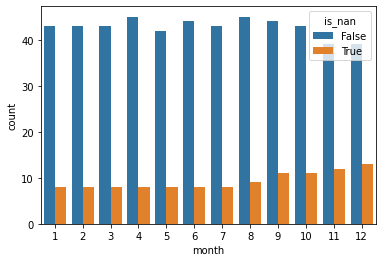

In [218]:
sns.countplot(data=df_sales[df_sales['year']==2017], x='month', hue='is_nan');

В среднем по месяцам почти 10% данных по ценам отсутствуют за 2017 год

In [219]:
df_sales['price'].describe()

count    1617.000000
mean        1.583406
std         0.629972
min         1.031200
25%         1.246254
50%         1.295835
75%         1.438110
max         3.632387
Name: price, dtype: float64

Заменю пропуски цен на 0 и посмотрю "просадки" на графиках

In [220]:
df_sales['price'].fillna(0, inplace=True)

In [221]:
df_sales['price'].isna().sum()

0

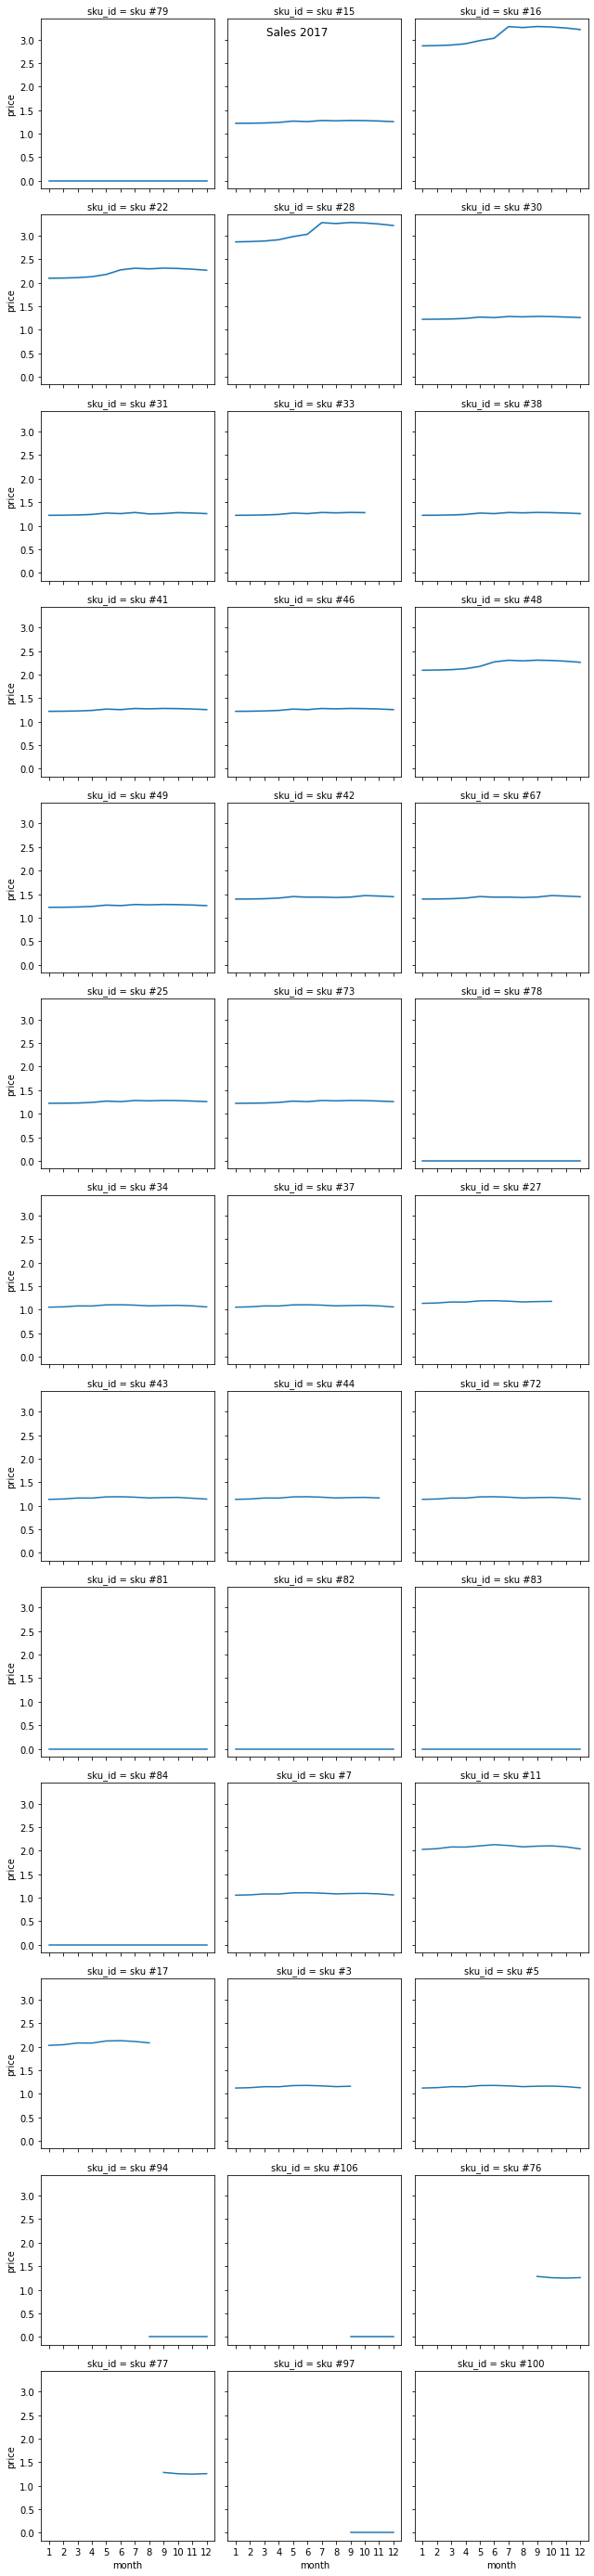

In [222]:
graph = sns.FacetGrid(df_sales[(df_sales['year'] == 2017)], col="sku_id"\
                    , col_wrap=3, height=3, margin_titles=True, despine=False)
graph.fig.suptitle('Sales 2017')
graph.set(xticks=range(1,13))
graph.map(sns.lineplot, "month", "price");

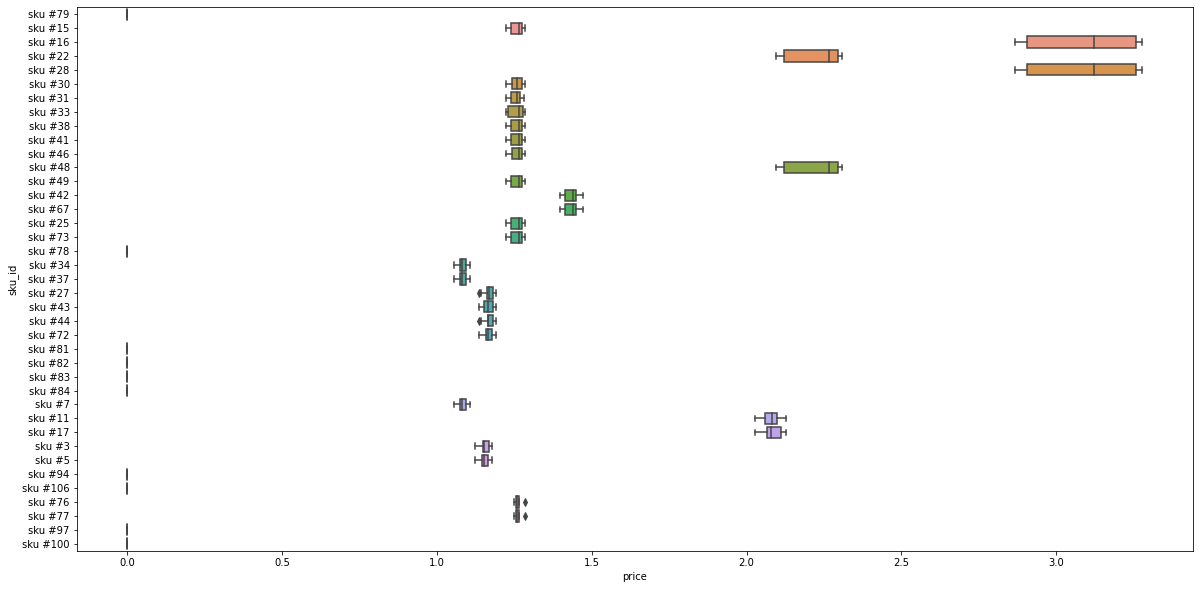

In [223]:
fsize = (20, 10)
fig, ax = plt.subplots(figsize=fsize)
sns.boxplot(data=df_sales[(df_sales['year']==2017)], y='sku_id', x='price');

Т.к. цена положительаня величина, то если среднее значение равно нулю, то у этого товара за выбранный период только пропуски по цене, выберу их:

In [224]:
df_sku_nan = df_sales[(df_sales['year']==2017)].groupby(['sku_id'])\
            .filter(lambda x: x['price'].mean() == 0.)['sku_id']\
            .value_counts().reset_index()
df_sku_nan

index  sku_id
0   sku #79      24
1   sku #78      24
2   sku #83      12
3   sku #81      12
4   sku #82      12
5   sku #84      12
6  sku #106       8
7   sku #97       4
8   sku #94       3
9  sku #100       1

In [225]:
df_sales[df_sales['sku_id'].isin(df_sku_nan['index'].values)]\
         .groupby(['sku_id'])['volume'].sum()

sku_id
sku #100     66132.0
sku #106     87234.0
sku #78     124620.0
sku #79     282636.0
sku #81     120684.0
sku #82      60744.0
sku #83      77562.0
sku #84      87870.0
sku #94      25686.0
sku #97     166422.0
Name: volume, dtype: float64

Полностью сходится с количеством NaN, значит нет товаров у которых цен нет частично за 2017 год, если NaN, то цен товара нет вообще, т.е. получается, что у этих товаров вообще нет никаких данных по ценам за 2017, при этом есть продажи, значит цену по каким то причинам не указали.

#### Более подробно о продажах

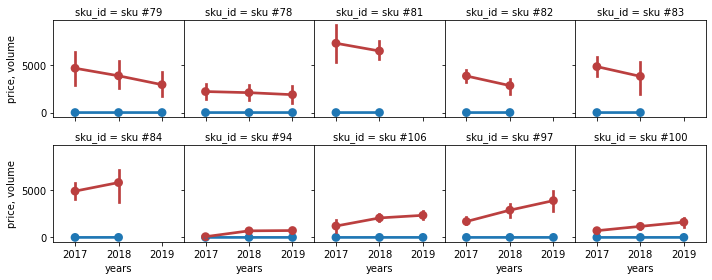

In [226]:
graph = (sns.FacetGrid(df_sales[df_sales['sku_id'].isin(df_sku_nan['index'].values)]
                     , col="sku_id", col_wrap=5, height=2
                     , margin_titles=True, despine=False))
graph.map(sns.pointplot, "year", "price", order=None);
graph.map(sns.pointplot, "year", "volume", color="#bb3f3f", order=None);
graph.set_axis_labels("years", "price, volume")
graph.fig.subplots_adjust(wspace=0)

Красным - продажи  
Синим - цена  


Данные по этим товарам есть за другие года, но есть и такие у кого данные только до 2018 года, т.е. нет ни цен, ни продаж за 2019.  
Т.к. постановка задачи звучит как сделать прогноз продаж на 3 мес с июля 2019, то для корректного предсказания нужны данные до 07.2019, иначе правдоподобность прогноза может быть сомнительной.  

А как обстоят дела с наличием цен и продаж по другим товарами за все года?

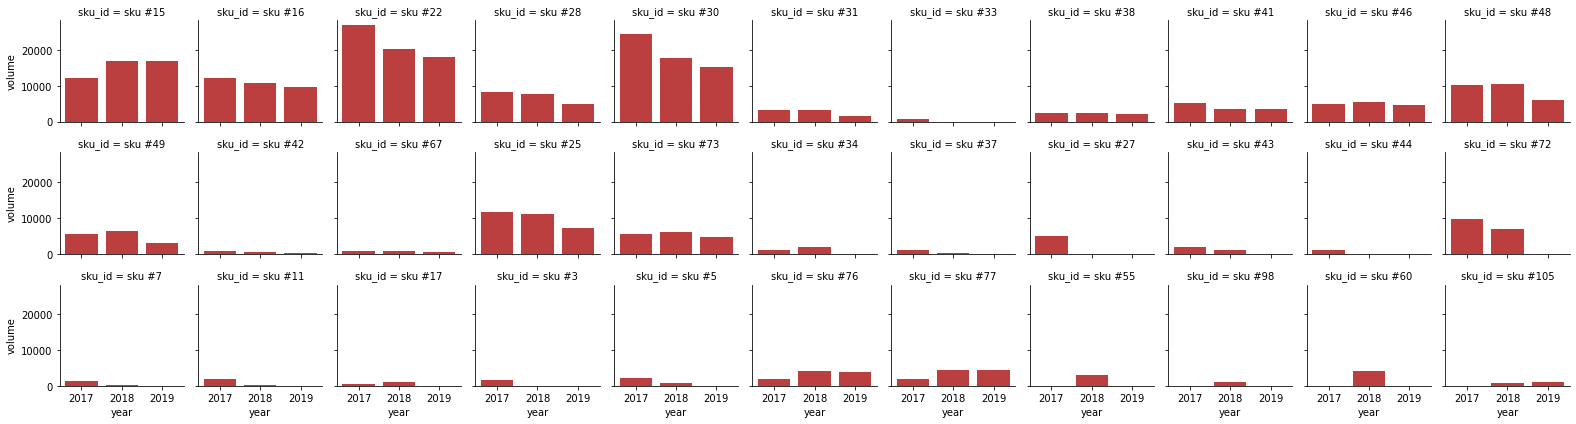

In [227]:
fgrid = sns.FacetGrid(data=df_sales[~df_sales['sku_id']\
                     .isin(df_sku_nan['index'].values)]\
                    , col="sku_id", col_wrap=11, height=2)
fgrid.map(plt.bar, "year", "volume", color="#bb3f3f");

Тоже существуют товары у которых нет данных по продажам за 2019 год.

#### Динамика продаж товаров за полный период

In [228]:
#Создам новый столбец с датой
df_sales['date'] = df_sales[['year','month']].apply(lambda r: '{}-{}'\
                           .format(r['year'], r['month']), axis=1)
df_sales['date'] = pd.to_datetime(df_sales['date'])

In [229]:
#используемая палитра цветов для городо
sns.color_palette("Set2", len(df_sales['ira'].unique()))

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [230]:
#палитра цветов для городов
colors_ira = (dict(zip(df_sales['location'].unique(), sns.color_palette("Set2"
                                           ,len(df_sales['ira'].unique())))))

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


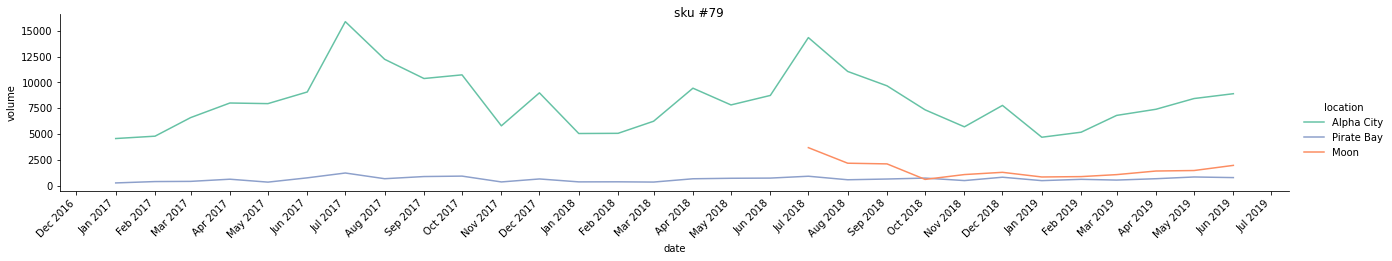

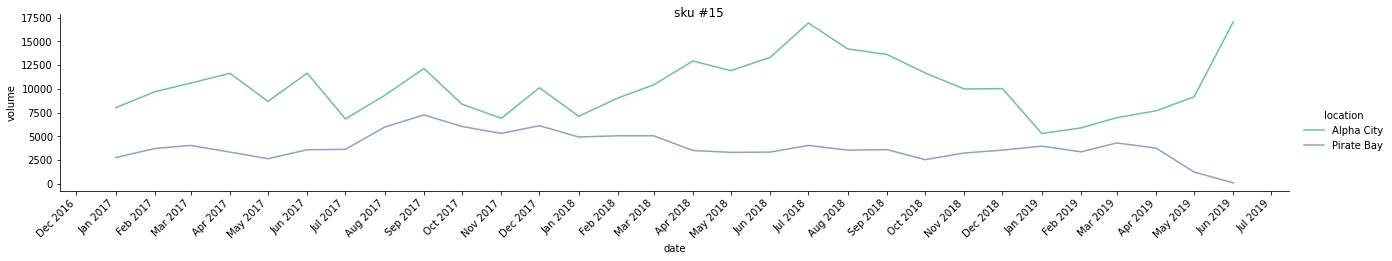

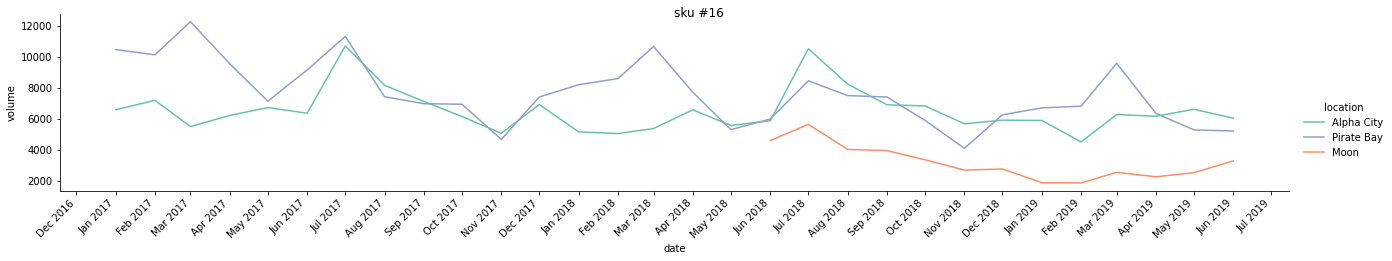

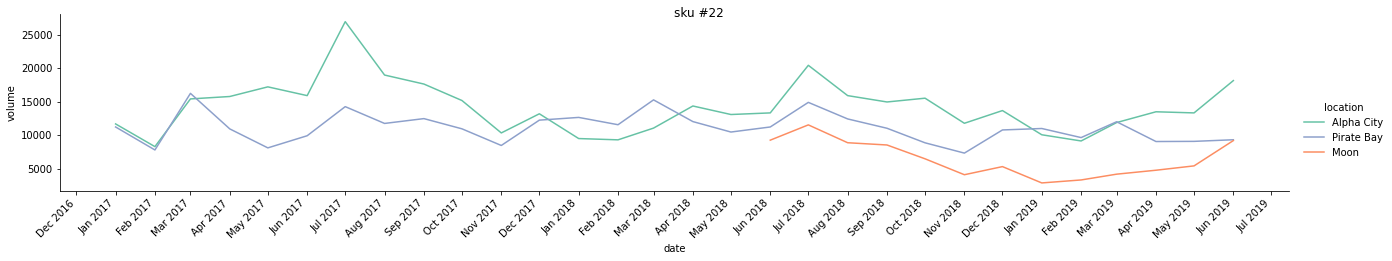

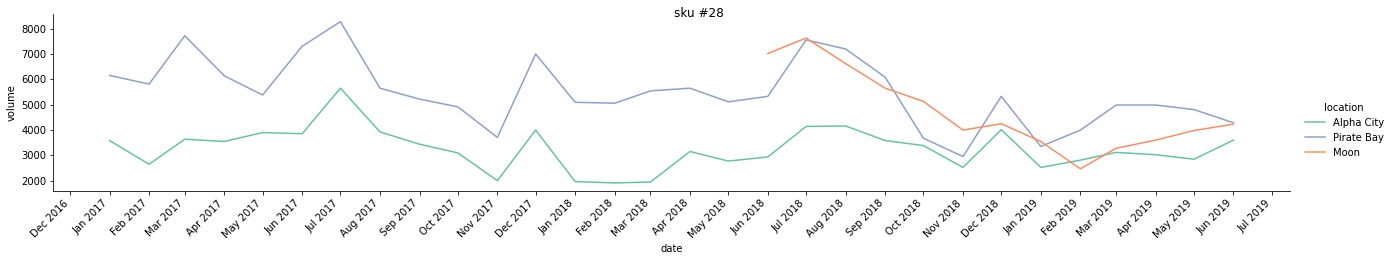

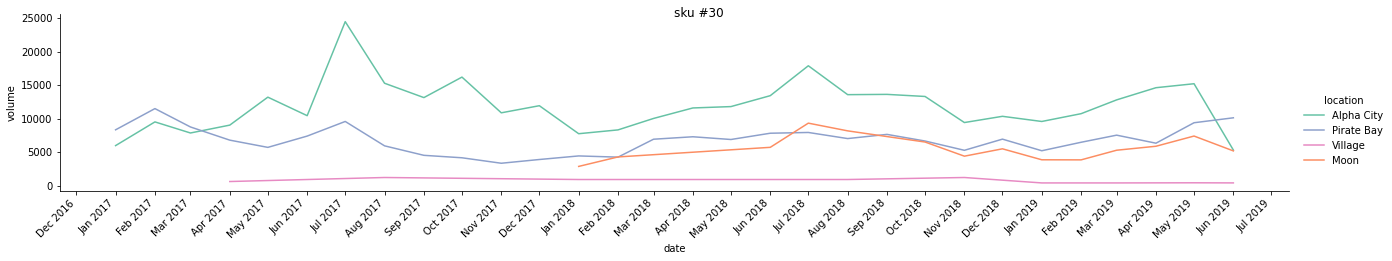

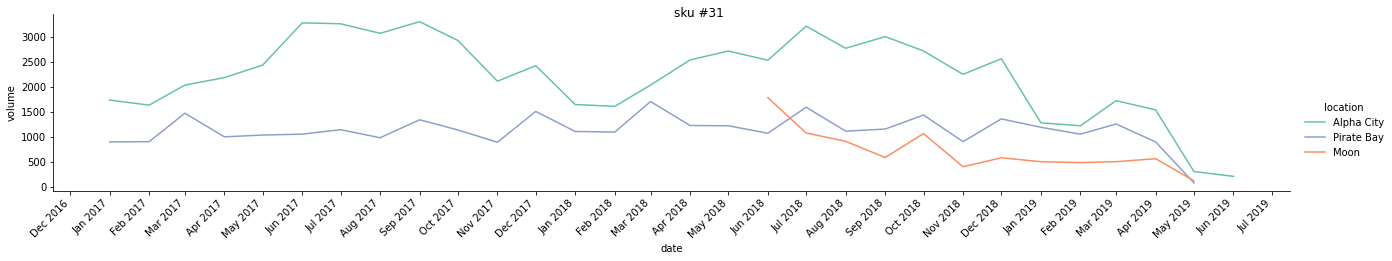

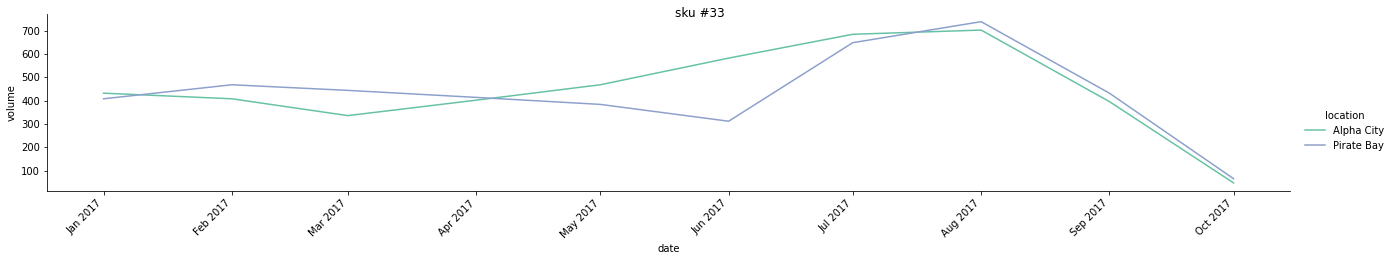

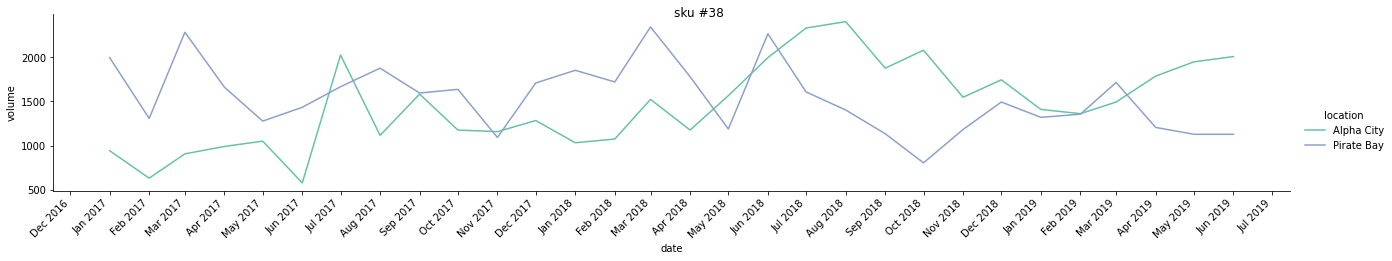

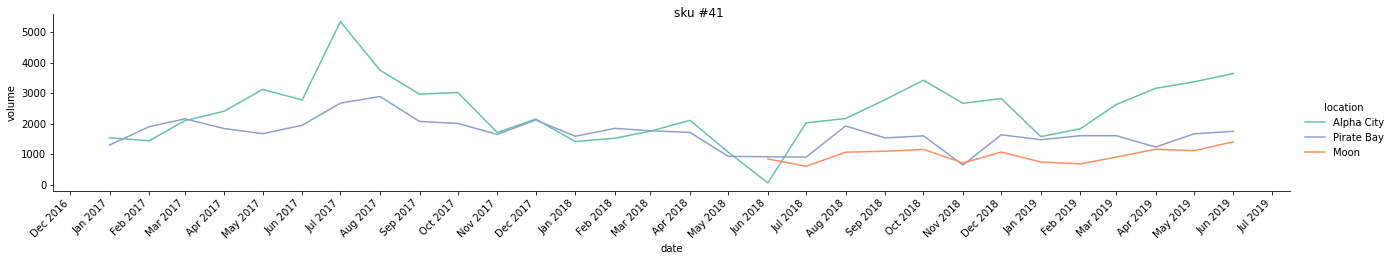

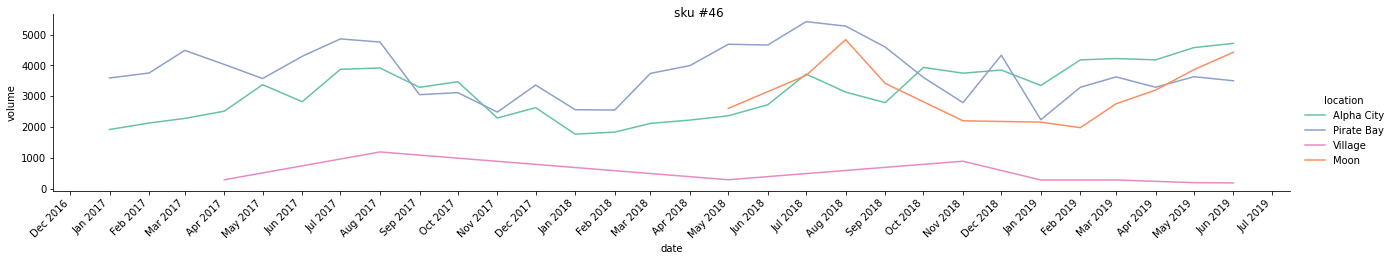

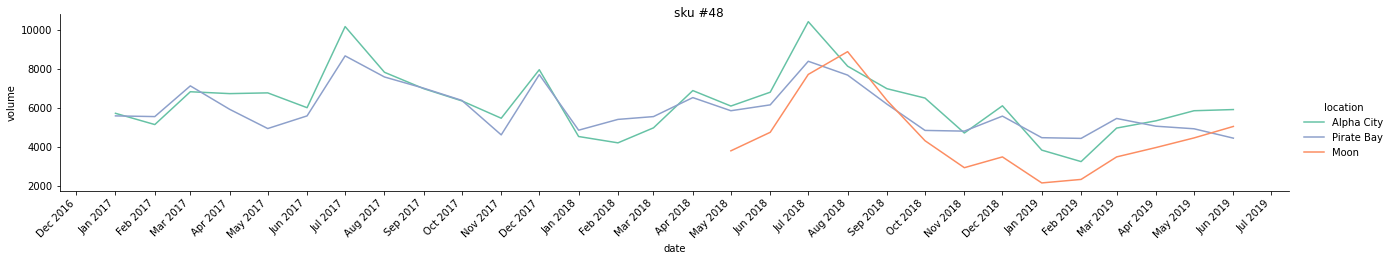

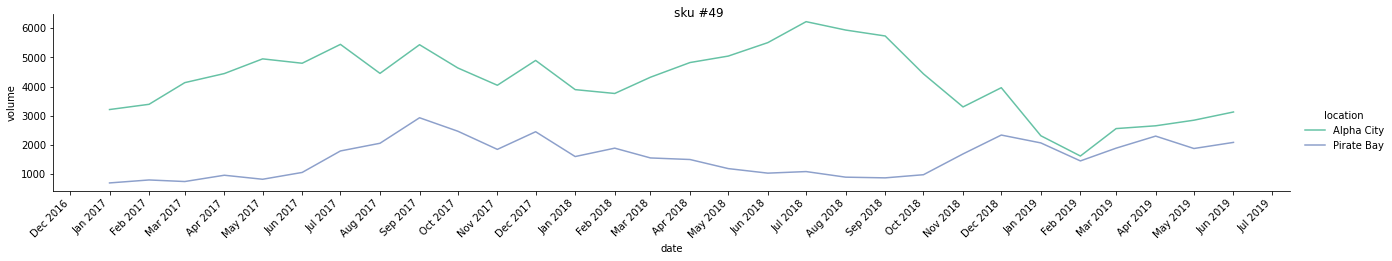

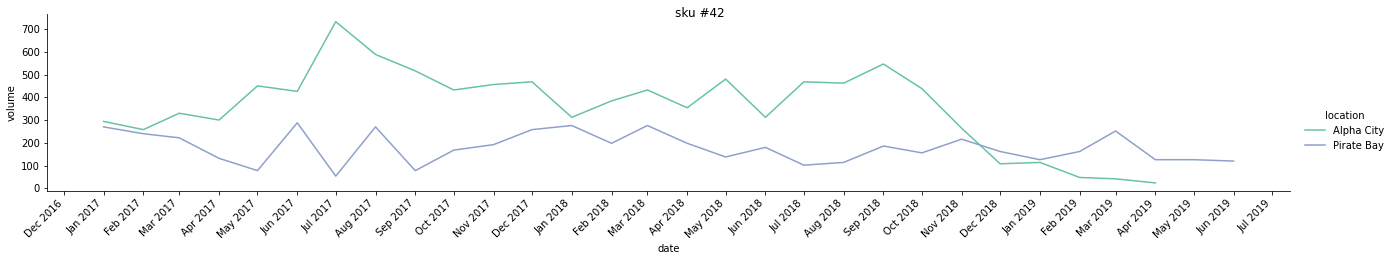

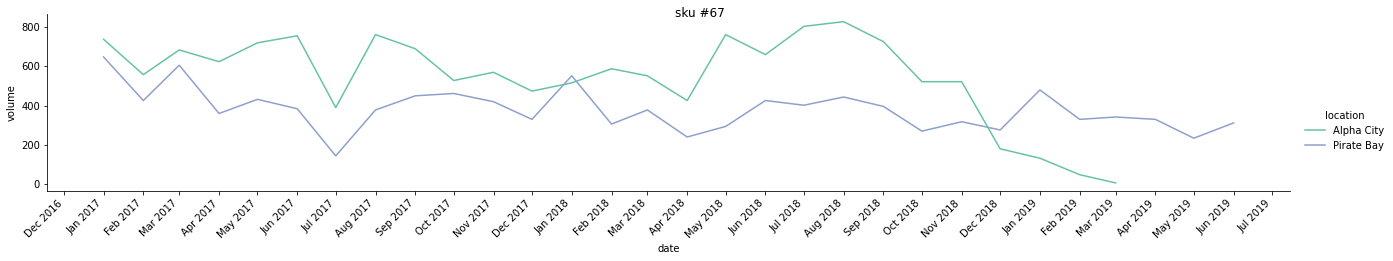

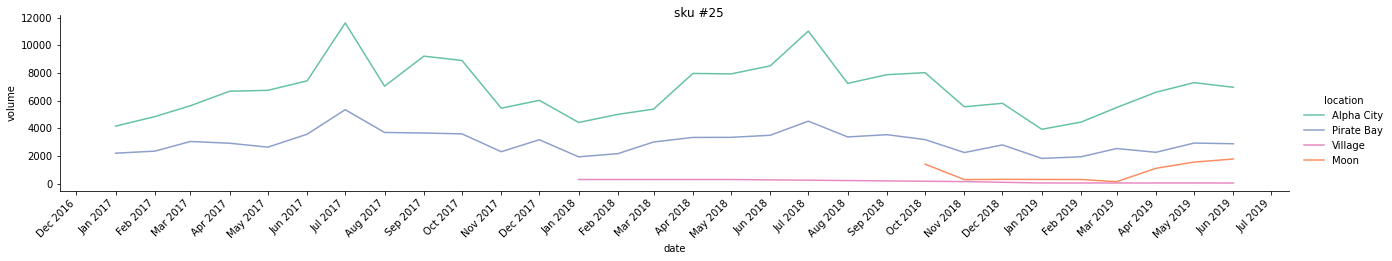

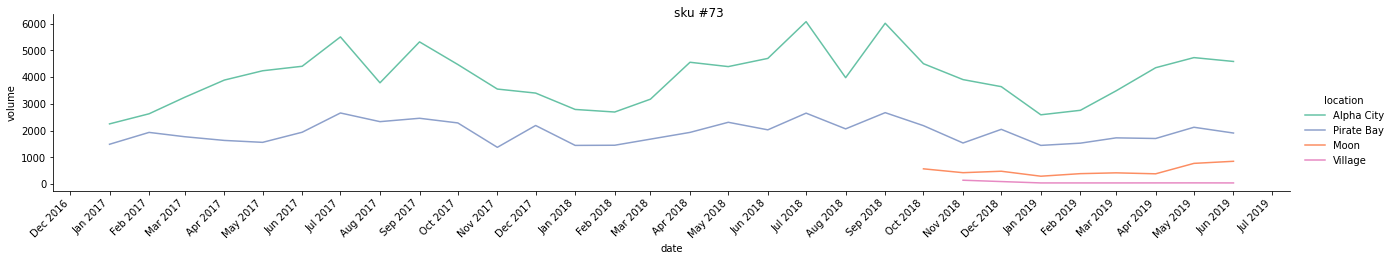

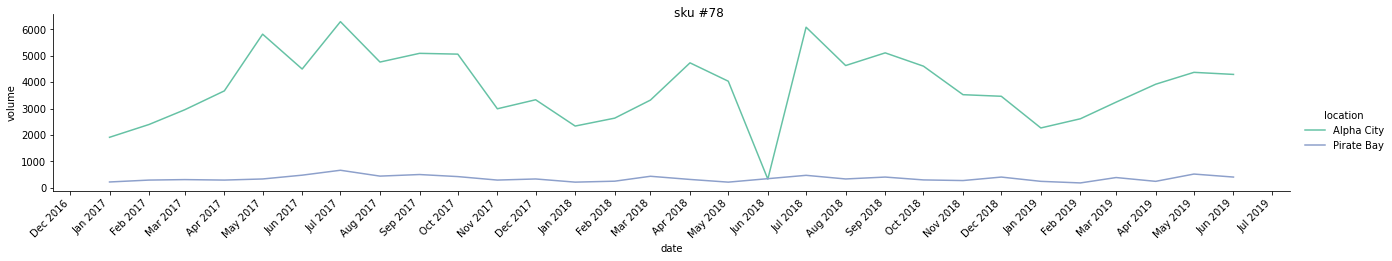

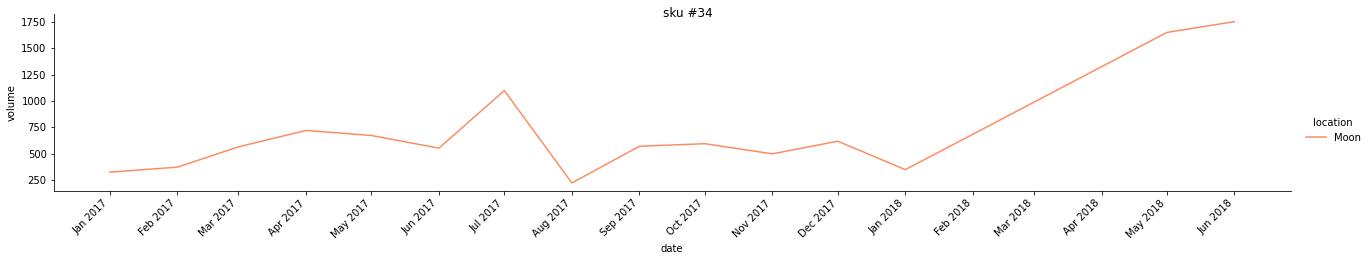

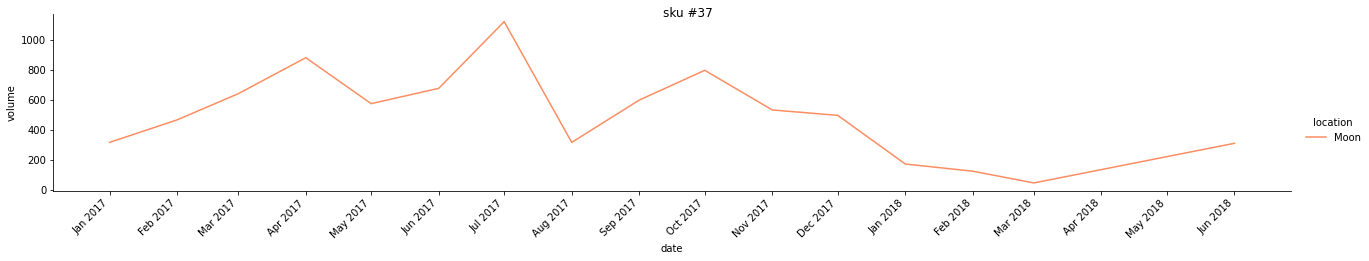

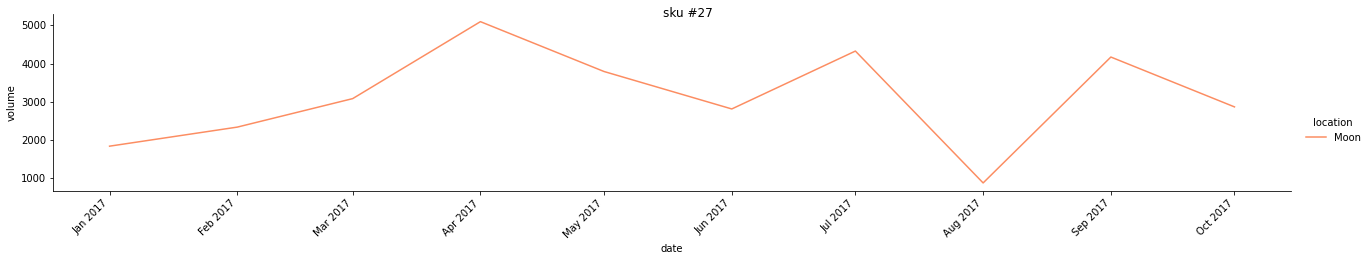

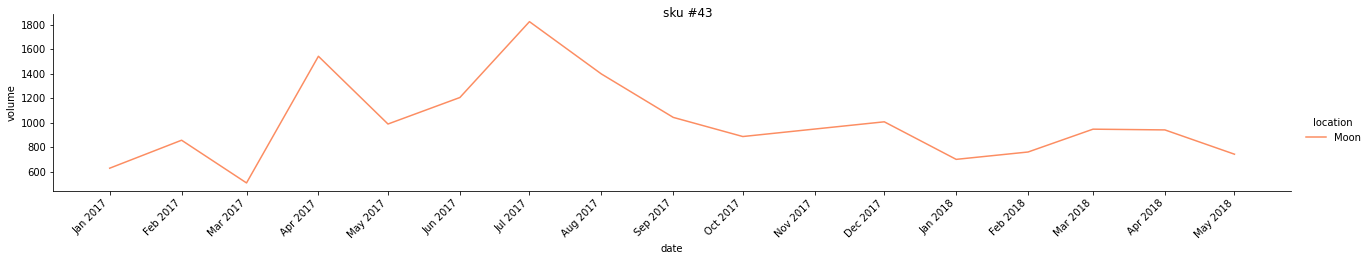

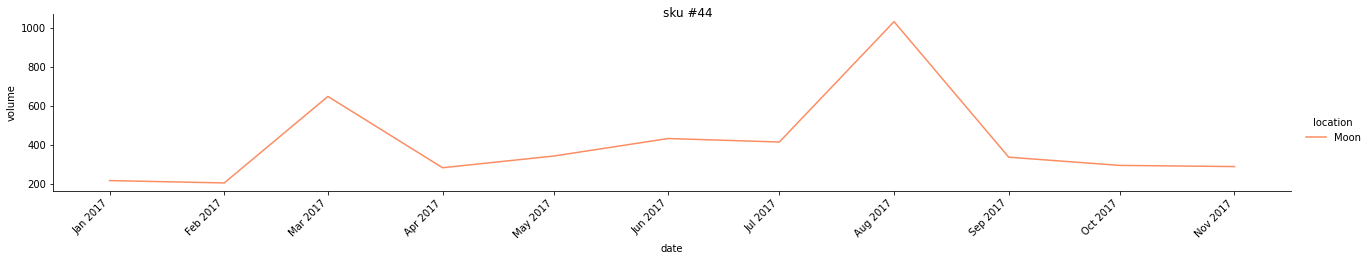

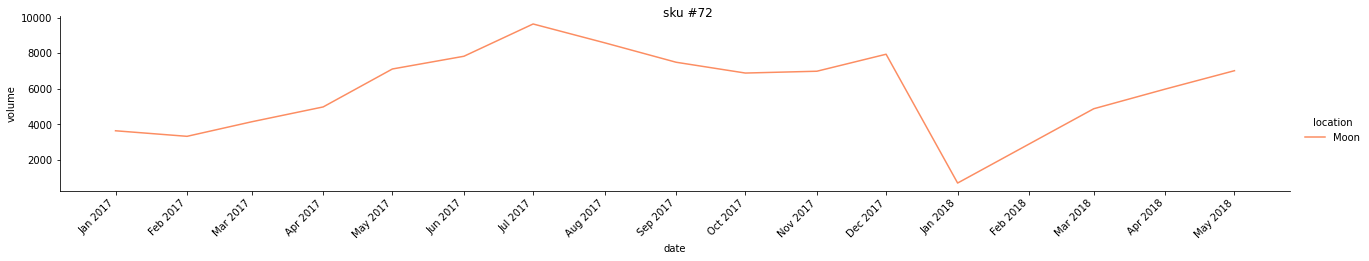

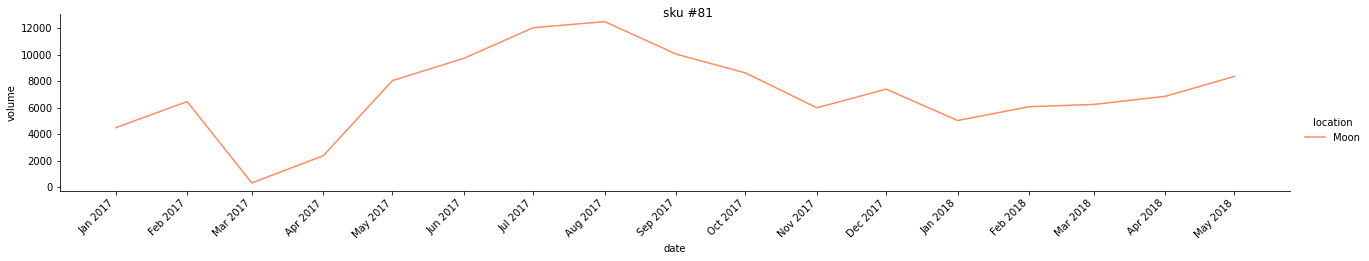

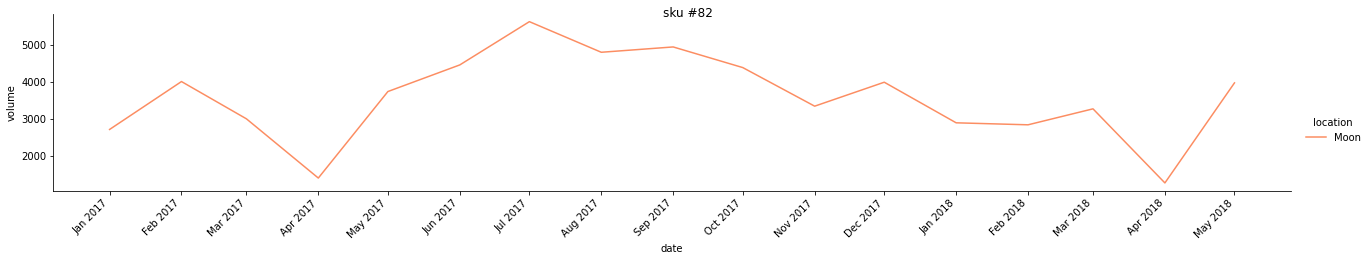

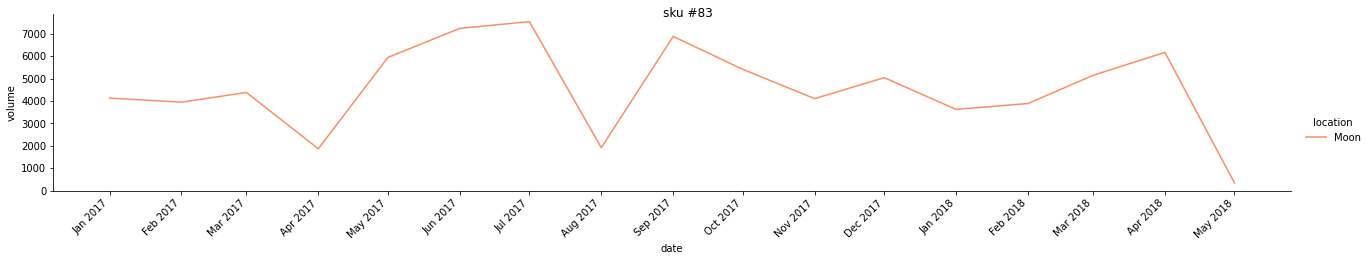

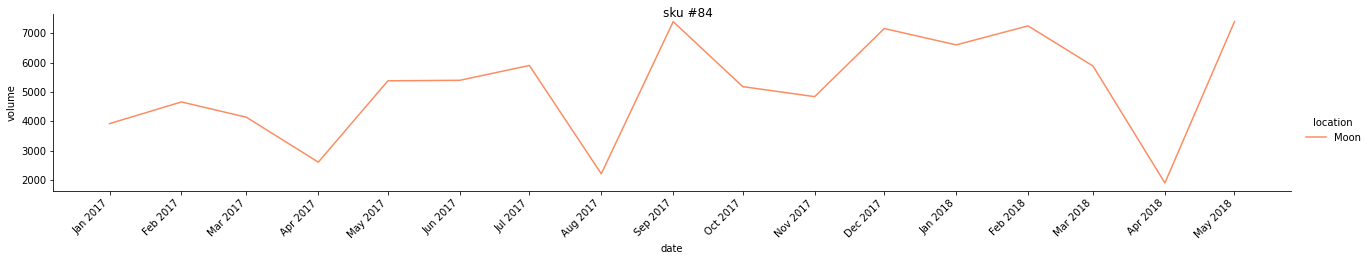

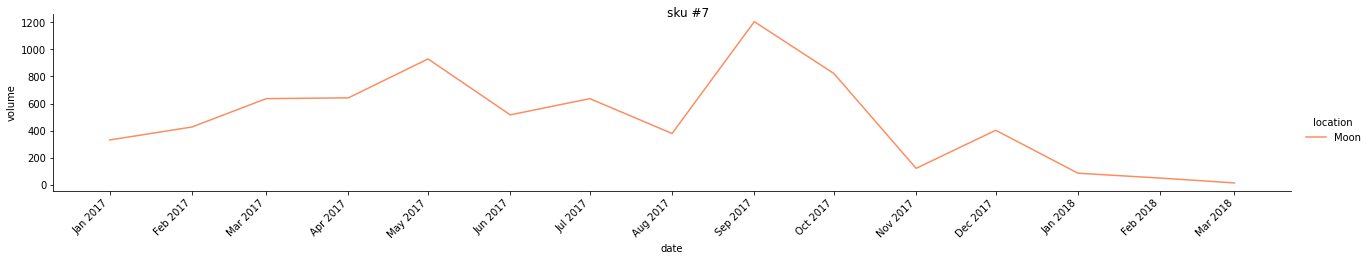

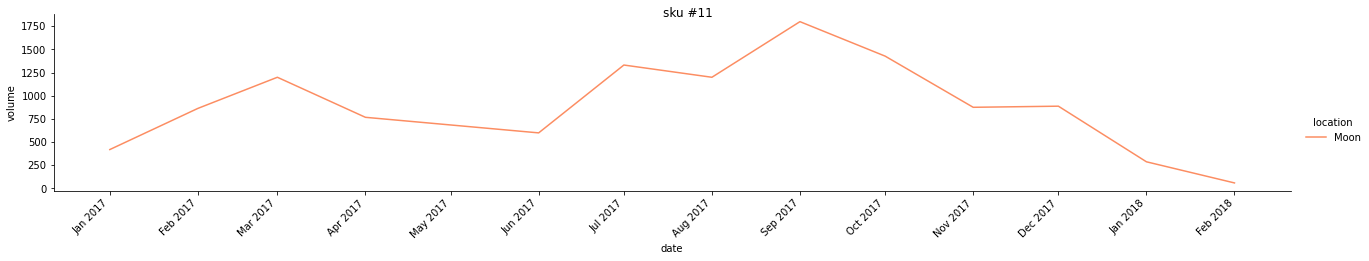

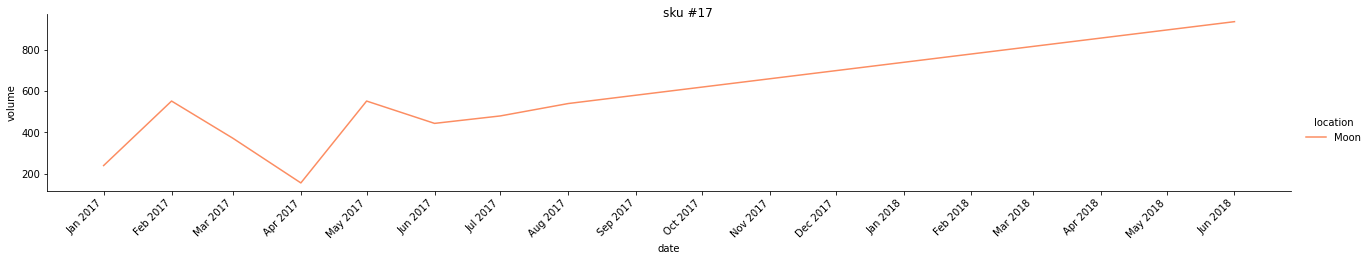

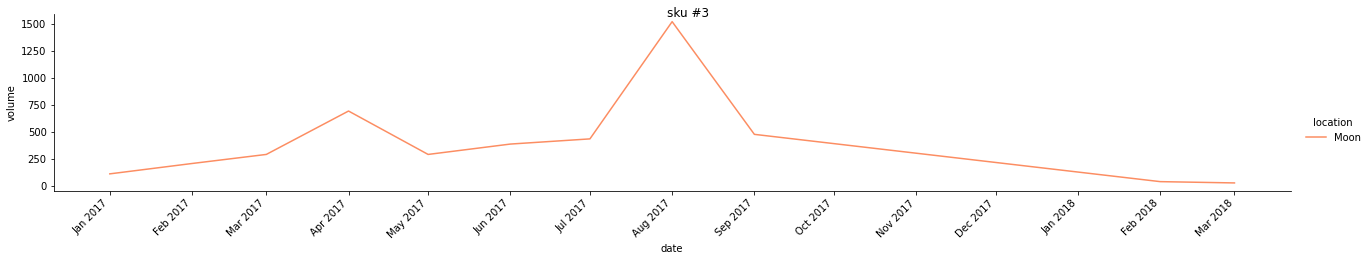

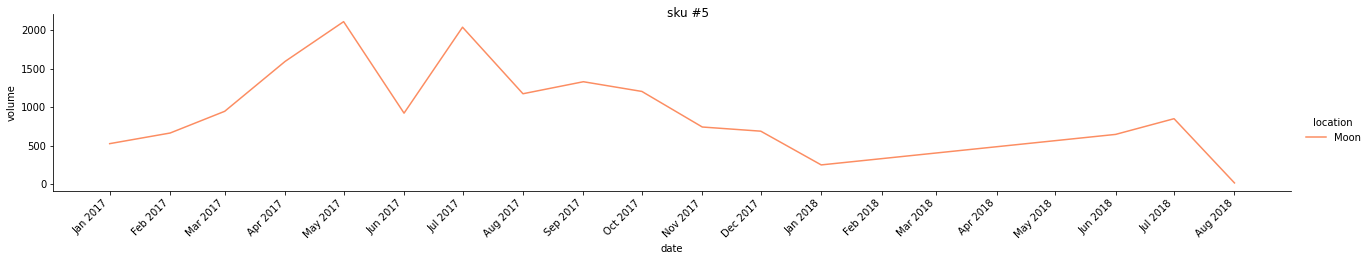

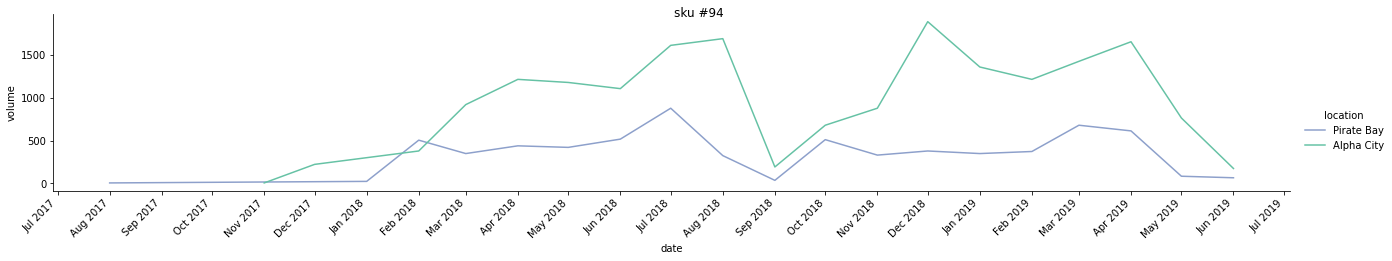

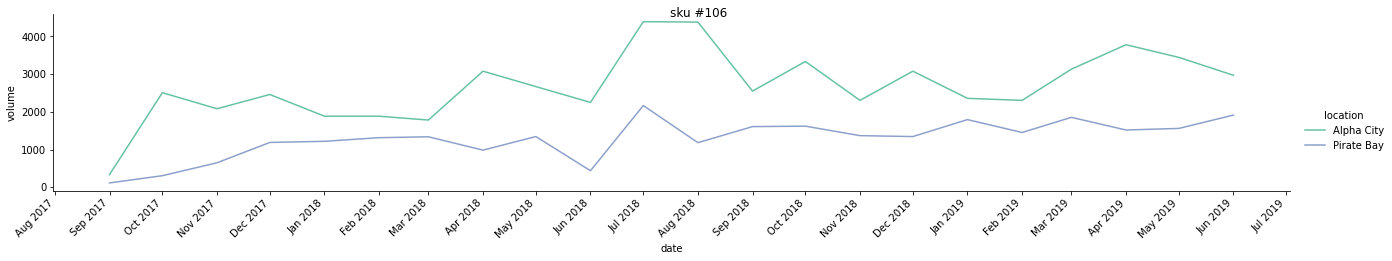

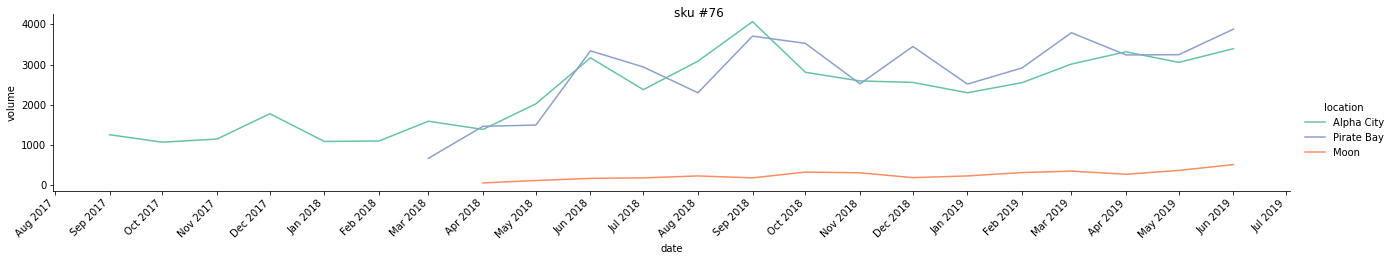

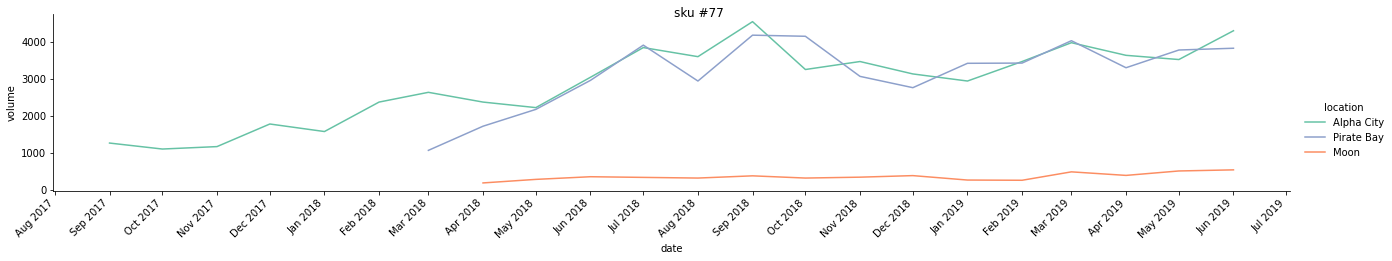

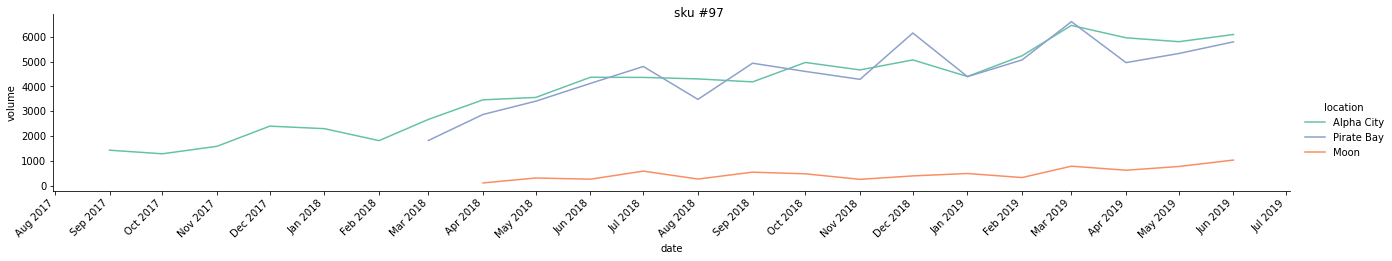

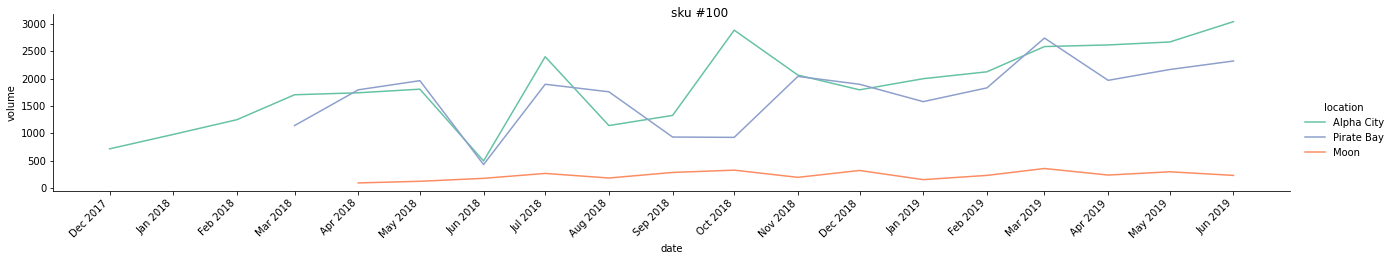

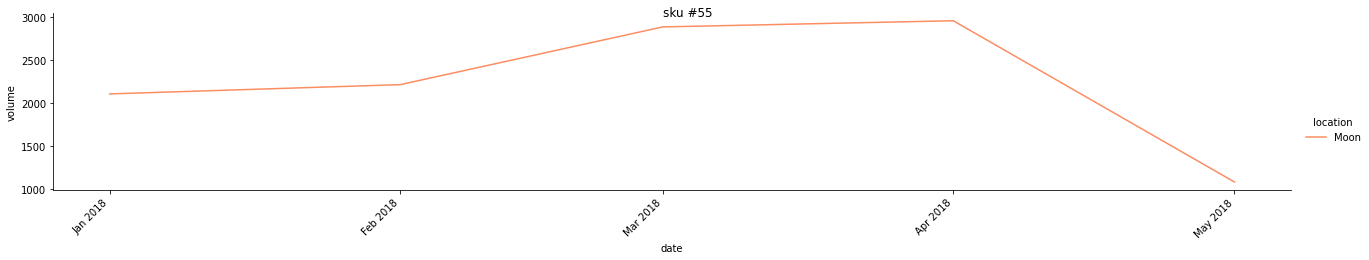

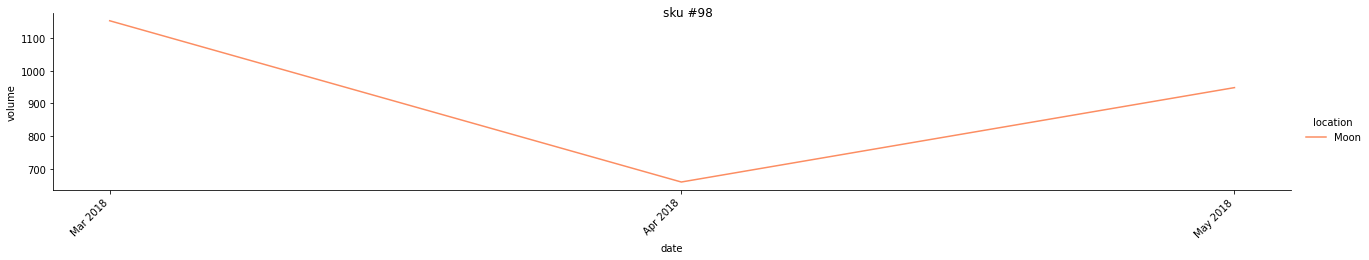

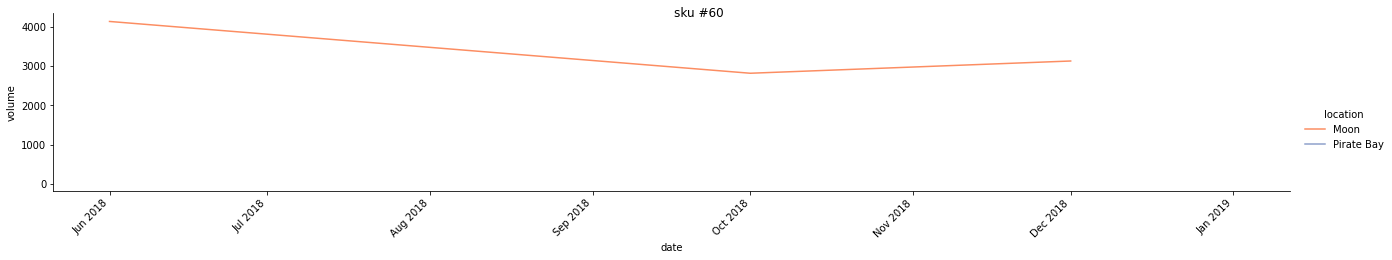

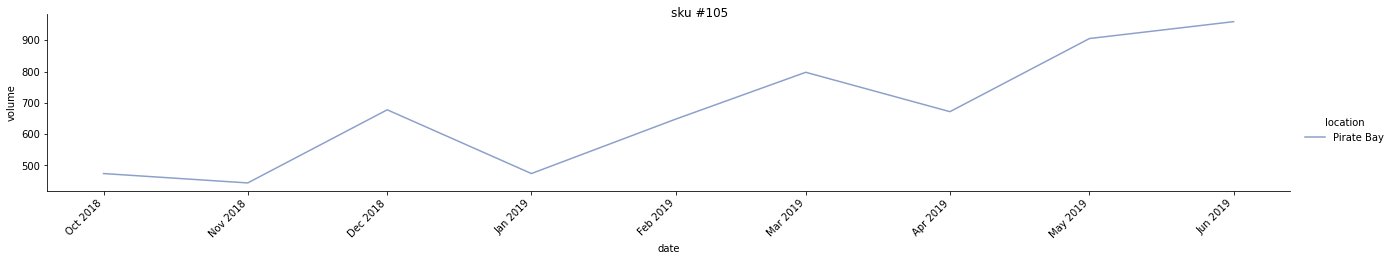

In [231]:
for sku in df_sales['sku_id'].unique():
    data=df_sales[df_sales['sku_id']==sku]
    graph=sns.relplot(
        data=data,
        x="date", y="volume",
        hue="location", 
        kind="line", palette=colors_ira,
        height=3, aspect=6, facet_kws=dict(sharex=False),
    )
    graph.ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    graph.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(graph.ax.get_xticklabels(), rotation=45, ha="right")
    graph.fig.suptitle(sku);

Какие наблюдения можно сделать:  
 - некоторые товары продаются только в определенных городах всегда
 - некоторые товары продавались только в определенных городах до определенного периода, затем перестали продавать вообще
 - часть товаров не поступало в часть городов до определенного момента или перестало поступать после
 - по части товаров данные по продаже есть не за каждый месяц, а например по квартально
 - есть товары, у которых слишком маленькая история продаж в определенных городах, т.е. продаются там относительно недавно 
 - по нескольким товарам много пиков продаж в июле, видимо связано с отпусками, но есть и товары у которых в июле есть провалы в продажах
 - есть товары, которые стабильно продавались, но затем продажи упали и они вовсе исчезли из оборота
 - есть товары у которых продажи падали до минимума а затем восстановились до пиков
 - есть товары по которым долгое время не было данных по продаже и затем появились

#### Продажи все товаров внутри города

In [232]:
#используемая палитра цветов для товаров
sns.color_palette("turbo_r", len(df_sales['sku_id'].unique()))

[(0.54583, 0.03593, 0.00638),
 (0.61923, 0.06367, 0.0041),
 (0.68602, 0.09536, 0.00481),
 (0.74617, 0.13098, 0.00851),
 (0.79971, 0.17055, 0.0152),
 (0.83926, 0.20654, 0.02305),
 (0.88066, 0.25334, 0.03521),
 (0.91572, 0.3053, 0.05134),
 (0.94538, 0.36638, 0.07461),
 (0.96904, 0.43399, 0.10294),
 (0.9859, 0.50479, 0.13367),
 (0.99419, 0.56386, 0.15918),
 (0.99654, 0.63193, 0.18738),
 (0.98986, 0.69382, 0.21043),
 (0.97323, 0.74682, 0.22536),
 (0.94489, 0.79634, 0.228),
 (0.91317, 0.83576, 0.22328),
 (0.86709, 0.87968, 0.21391),
 (0.8141, 0.91861, 0.20552),
 (0.75617, 0.95121, 0.20343),
 (0.69525, 0.9761, 0.21294),
 (0.63323, 0.99195, 0.23937),
 (0.57357, 0.99817, 0.27712),
 (0.48879, 0.99828, 0.33816),
 (0.39678, 0.99098, 0.41098),
 (0.30513, 0.97697, 0.48987),
 (0.22142, 0.95692, 0.56914),
 (0.16319, 0.93609, 0.63137),
 (0.11374, 0.90673, 0.69651),
 (0.0932, 0.87211, 0.75237),
 (0.10026, 0.82955, 0.81389),
 (0.12698, 0.78037, 0.8759),
 (0.16529, 0.7262, 0.93161),
 (0.20021, 0.67842, 0.96833),
 (0.23874, 0.61931, 0.99485),
 (0.26592, 0.55979, 0.99583),
 (0.27543, 0.50115, 0.96594),
 (0.27691, 0.44145, 0.91328),
 (0.27429, 0.39043, 0.85393),
 (0.26652, 0.32768, 0.76412),
 (0.25369, 0.26327, 0.65406),
 (0.23582, 0.1972, 0.52373),
 (0.21291, 0.12947, 0.37314)]

In [233]:
colors_sku = dict(zip(df_sales['sku_id'].unique(), sns.color_palette
                      ("turbo_r", len(df_sales['sku_id'].unique()))))

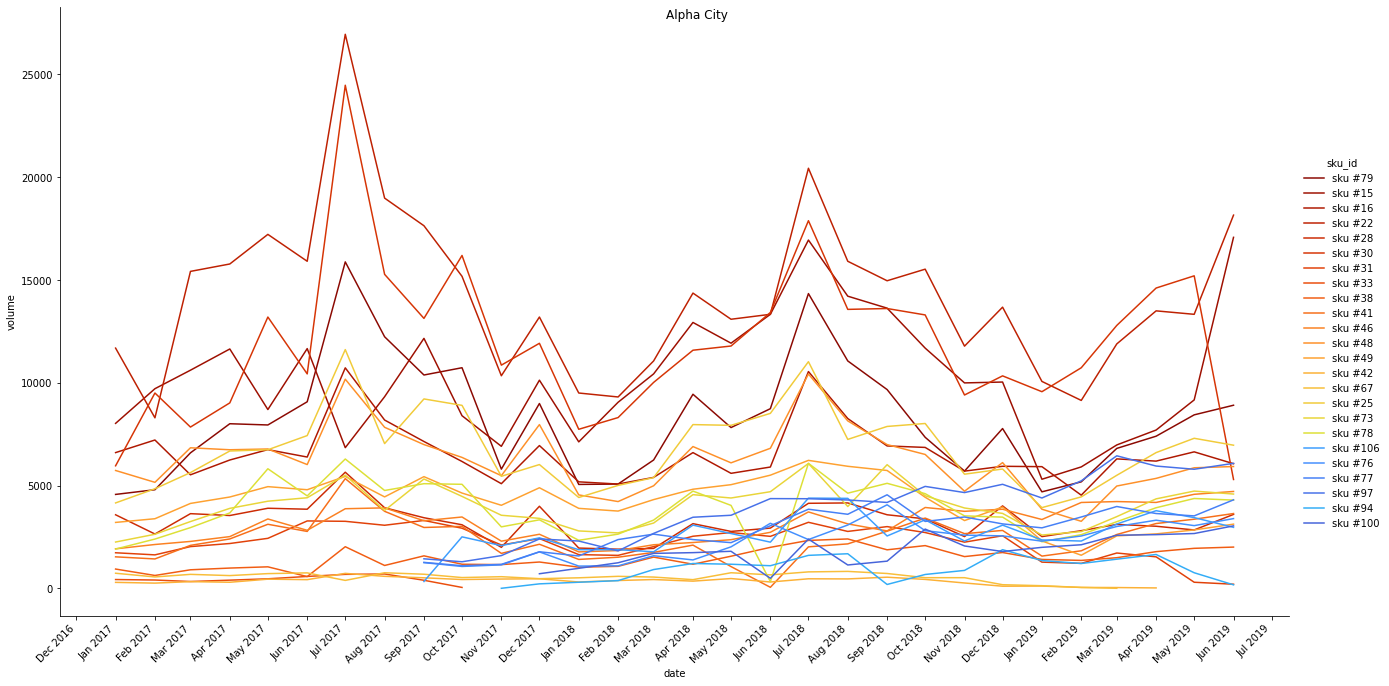

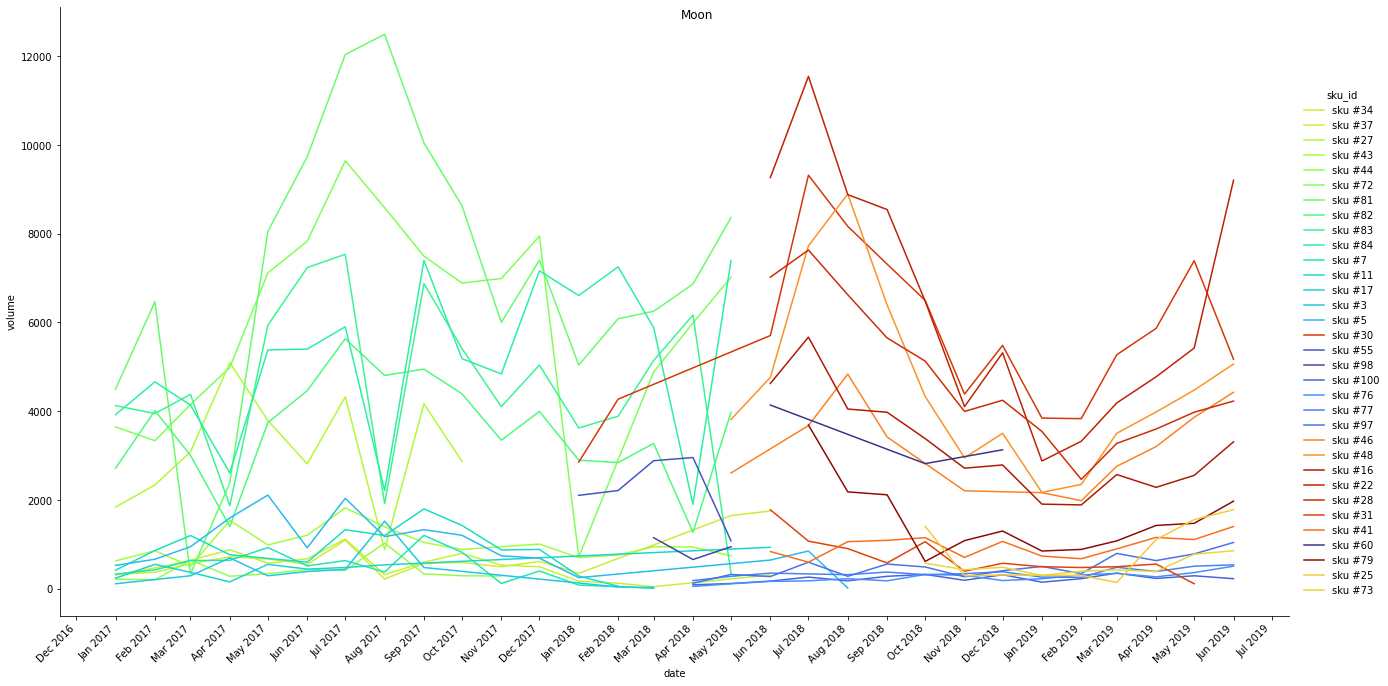

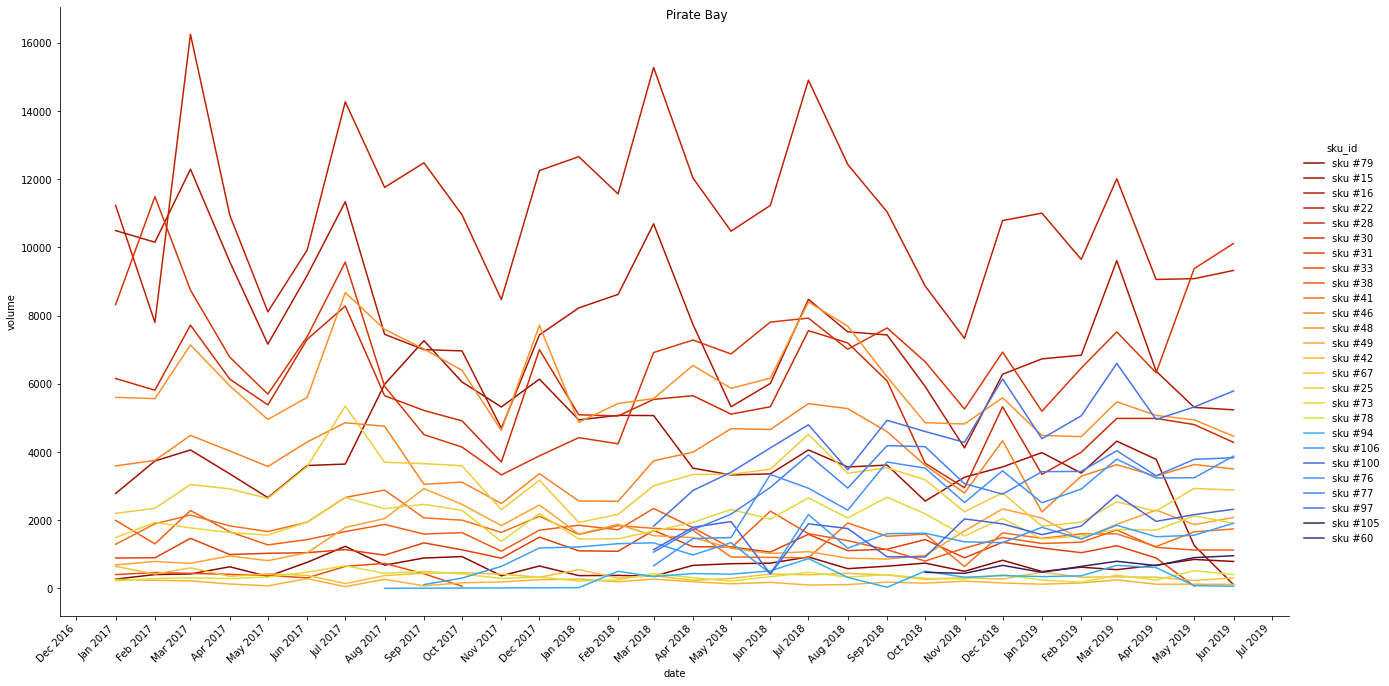

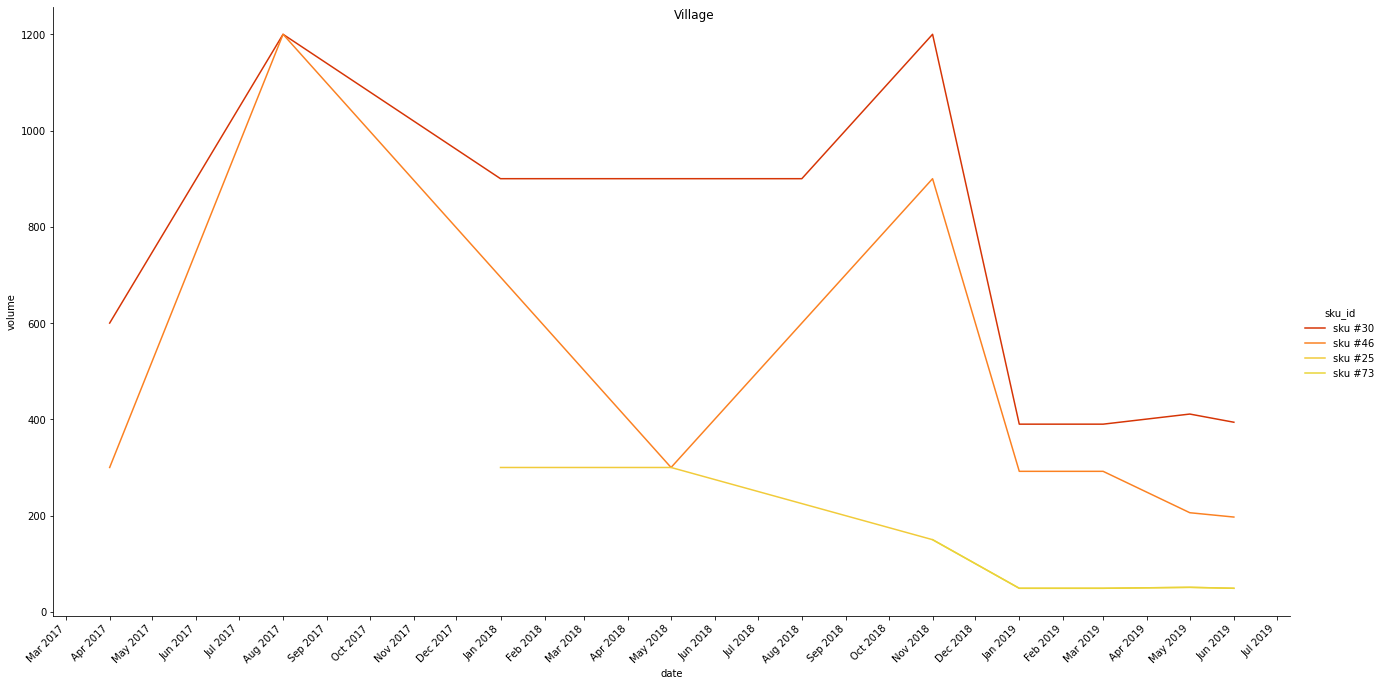

In [234]:
for loc in df_sales['location'].unique():
    data=df_sales[df_sales['location']==loc]
    graph=sns.relplot(
        data=data,
        x="date", y="volume",
        hue="sku_id", 
        kind="line", palette=colors_sku,
        height=9, aspect=2, facet_kws=dict(sharex=False),
    )
    graph.ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    graph.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(graph.ax.get_xticklabels(), rotation=45, ha="right")
    graph.fig.suptitle(loc);

Какие наблюдения можно сделать:
 - не все товары которые продаются в конкретном городе продавались там всегда, какие то появлялись позже, какие то переставали продаваться
 - например в городе "Moon" сначала продавались одни товары (причем эти товары продавались только тут), затем, был полностью изменен ассортимент на другие товары
 - какие то товары в одних городах начали продаваться раньше чем в других
 - по многим товарам пики продаж совпадают
 - по "Village", продается всего 4 товара, данные по продажам есть раз в несколько месяцев, видимо название говорит само за себя, в деревне спрос не большой и нет необходимости в большом ассортименте и поставкам товаров каждый месяц и с ноября 2018 все продажи резко упали

#### Какие товары продаются лучше?

Средние продажи всех товаров за весь период:

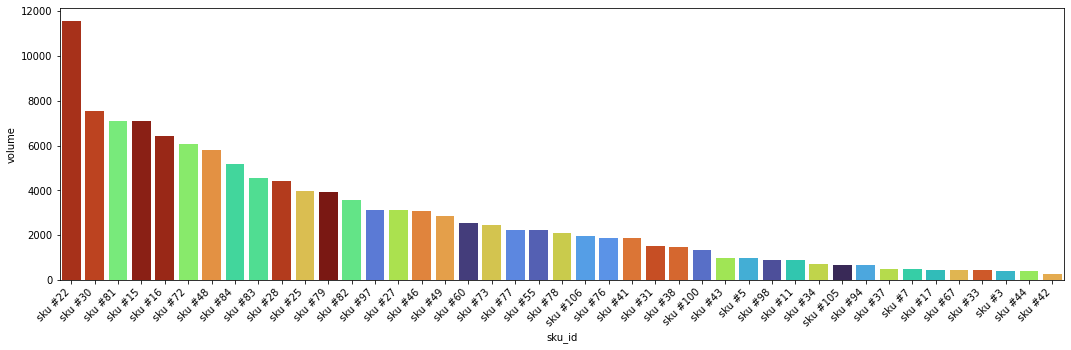

In [235]:
fsize = (18, 5)
fig, ax = plt.subplots(figsize=fsize)
data = df_sales.groupby('sku_id')['volume'].mean().reset_index()\
               .sort_values('volume', ascending=False)
sns.barplot(data=data, x='sku_id', y='volume', palette=colors_sku);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right");

По годам:

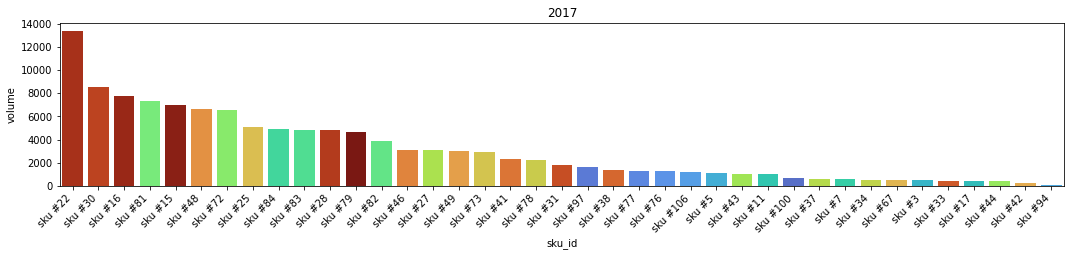

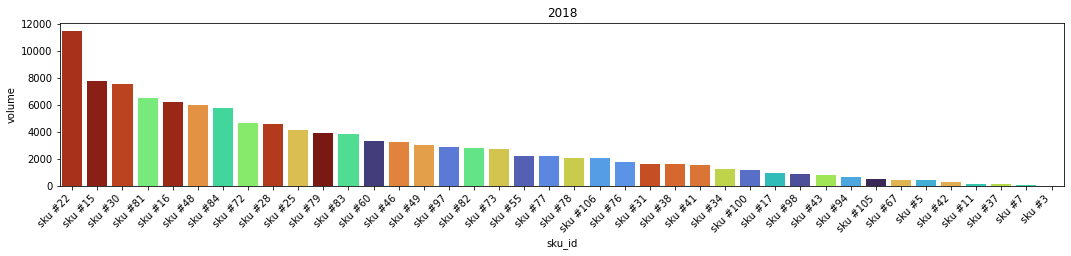

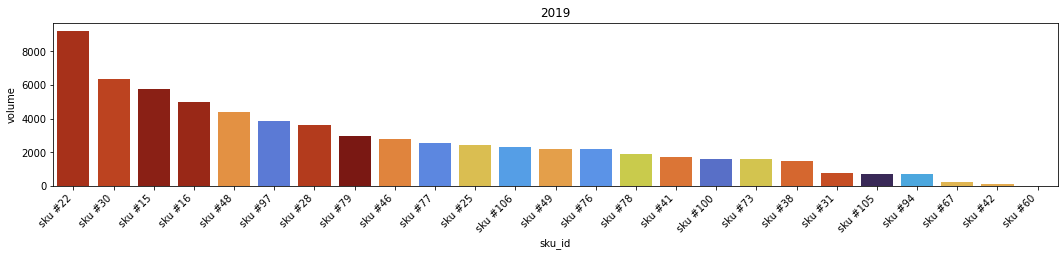

In [236]:
for year in df_sales['year'].unique():
    fsize = (18, 3)
    fig, ax = plt.subplots(figsize=fsize)
    data = df_sales[df_sales['year']==year].groupby('sku_id')['volume']\
          .mean().reset_index().sort_values('volume', ascending=False)
    plt.title(year)
    sns.barplot(data=data, x='sku_id', y='volume', palette=colors_sku);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right");

Если в 2017 и 2018 годах топ 10 товаров по продажам был примерно одинаковый, то в 2019 году топ изменился, часть товаров вообще исчезла из продаж, например 'sku #81', 'sku #84' да и в целом "зеленые" товары.

Посмотрим на средние продажи топ 10 товаров в каждом городе:

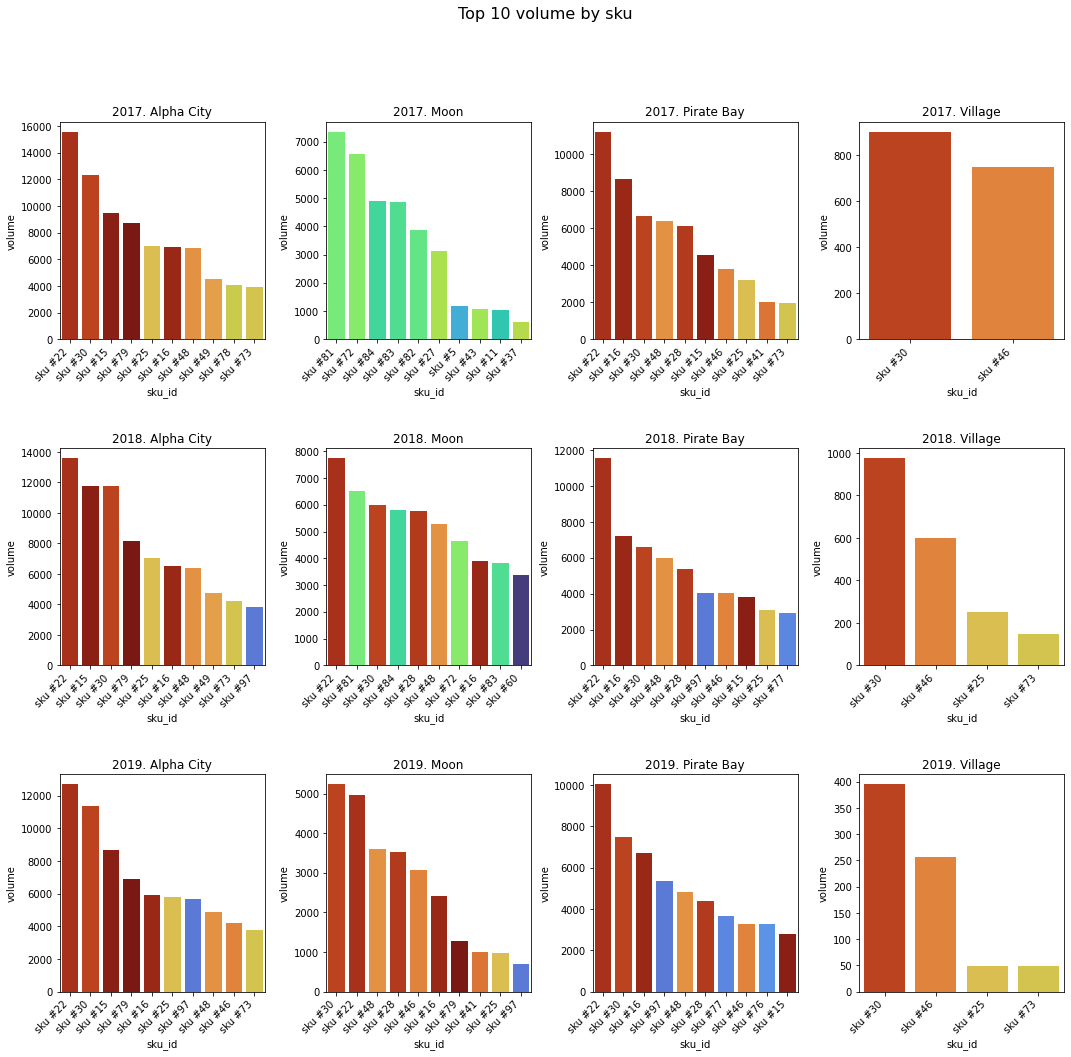

In [237]:
data = df_sales.groupby(['sku_id','year','location'])['volume'].mean()\
                                                               .reset_index()
years = data['year'].unique()
locations = data['location'].unique()
top_sku_volume = 10

fig, axes = plt.subplots(nrows=len(years), ncols=len(locations)\
                        , figsize=(18, 16))
fig.suptitle('Top {} volume by sku'.format(top_sku_volume), fontsize=16)

for row, row_axes in enumerate(axes):
    year = years[row]
    data_row = data[data['year'] == year]
    i=0
    for column, ax in enumerate(row_axes):
        location = locations[i]
        top_in_loc = data_row[data_row['location'] == location].sort_values('volume', ascending=False).head(top_sku_volume)
        sns.barplot(data=top_in_loc, x='sku_id', y='volume', palette=colors_sku, ax=ax);
        ax.set_title('{}. {}'.format(year, location))
        i+=1
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.subplots_adjust(hspace=0.5, wspace=0.3)


Интересно как в Moon менялся ассортимент, сначала все "зеленые" товары были на половину заменены на "коричневые" а затем вовсе ушли.  
А в Viliage ассортимент увеличился в 2 раза! :)

#### Посмотрим на остальные характеристики товара и их влияние на продажи

Для начала нужно понять у товаров с уникальными ИД (sku_id) уникальные характеристики или например есть товары с одинаковым ИД но один содержит алкоголь а другой нет.

In [238]:
df_sales_pivot = (pd.pivot_table(df_sales
        , values=['volume'], index=['sku_id']
        , columns=['filling','shape','with_alcohol','item_per_bundle','brand']
        , aggfunc={'volume':'count'}))
df_sales_pivot.count(axis=1).values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Т.к. все единицы, то уникальные товары имеют уникальные характеристики.

С какими характеристиками товаров продается больше и какие средние продажи:

In [239]:
df_sales_pivot = (pd.pivot_table(df_sales
    , values=['sku_id', 'volume']
    , index=[ 'product_category', 'brand', 'with_alcohol', 'item_per_bundle'] 
    , columns=['filling','shape'], aggfunc={'sku_id':'count', 'volume':'mean'}
    , fill_value=0
    ).round(1))
df_sales_pivot

sku_id          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                     0       0   
                 Ferrero Rocher No           1                     9      74   
                                             2                     0       0   
                                             3                     0       0   
                                Yes          1                     0       0   
                 Milka          No           1                     0       0   
                 Snickers       No           1                     0       0   
                 Toblerone      No           1                     0       0   
                                             2                     0       0   
                 Twix           No           1                     0       0   
Lollipops        Chupa Chups    No           1                     0       0   
                                Yes          1                     0       0   

                                                                             \
filling                                                                Nuts   
shape                                                        Standart Round   
product_category brand          with_alcohol item_per_bundle                  
Chocolates       Cadbury        No           1                    103     0   
                 Ferrero Rocher No           1                    485     0   
                                             2                    181     0   
                                             3                    180     0   
                                Yes          1                     60     0   
                 Milka          No           1                    115     0   
                 Snickers       No           1                     54     0   
                 Toblerone      No           1                    178     0   
                                             2                     22     0   
                 Twix           No           1                     59     0   
Lollipops        Chupa Chups    No           1                      0   106   
                                Yes          1                      0   103   

                                                              volume          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                   0.0     0.0   
                 Ferrero Rocher No           1                 672.7  1490.4   
                                             2                   0.0     0.0   
                                             3                   0.0     0.0   
                                Yes          1                   0.0     0.0   
                 Milka          No           1                   0.0     0.0   
                 Snickers       No           1                   0.0     0.0   
                 Toblerone      No           1                   0.0     0.0   
                                             2                   0.0     0.0   
                 Twix           No           1                   0.0     0.0   
Lollipops        Chupa Chups    No           1                   0.0     0.0   
                                Yes          1                   0.0     0.0   

                                                                               
filling                                                                  Nuts  
shape                                                        Standart   Rou

"Chupa Chups" с алкоголем ... интересно ...

Больше всего товаров поставляется без начинки, без алкоголя, стандартной формы и единичной упаковки, но средний объем продаж выше у товаров с теми же характеристиками но по 3 и 2 штуки в упаковке.

In [240]:
def volume_for_one_sku(in_table):
    '''
    На основе сводной таблицы объема продаж рассчитывает 
    таблицу объема продаж на единицу товара
    '''
    out_table = in_table
    count_cols = int(len(in_table.columns)/2) #Т.к. у нас в первой половине таблицы количетсво продаж а в правой объем, то нужно левую часть поделить на правую
    for i in range(count_cols): 
        out_table[out_table.columns[i+count_cols]] = \
          in_table[in_table.columns[i+count_cols]] / \
          in_table[in_table.columns[i]]
    
    return out_table.fillna(0).round(1)

In [241]:
volume_for_one_sku(df_sales_pivot)

sku_id          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                     0       0   
                 Ferrero Rocher No           1                     9      74   
                                             2                     0       0   
                                             3                     0       0   
                                Yes          1                     0       0   
                 Milka          No           1                     0       0   
                 Snickers       No           1                     0       0   
                 Toblerone      No           1                     0       0   
                                             2                     0       0   
                 Twix           No           1                     0       0   
Lollipops        Chupa Chups    No           1                     0       0   
                                Yes          1                     0       0   

                                                                             \
filling                                                                Nuts   
shape                                                        Standart Round   
product_category brand          with_alcohol item_per_bundle                  
Chocolates       Cadbury        No           1                    103     0   
                 Ferrero Rocher No           1                    485     0   
                                             2                    181     0   
                                             3                    180     0   
                                Yes          1                     60     0   
                 Milka          No           1                    115     0   
                 Snickers       No           1                     54     0   
                 Toblerone      No           1                    178     0   
                                             2                     22     0   
                 Twix           No           1                     59     0   
Lollipops        Chupa Chups    No           1                      0   106   
                                Yes          1                      0   103   

                                                              volume          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                   0.0     0.0   
                 Ferrero Rocher No           1                  74.7    20.1   
                                             2                   0.0     0.0   
                                             3                   0.0     0.0   
                                Yes          1                   0.0     0.0   
                 Milka          No           1                   0.0     0.0   
                 Snickers       No           1                   0.0     0.0   
                 Toblerone      No           1                   0.0     0.0   
                                             2                   0.0     0.0   
                 Twix           No           1                   0.0     0.0   
Lollipops        Chupa Chups    No           1                   0.0     0.0   
                                Yes          1                   0.0     0.0   

                                                                             
filling                                                                Nuts  
shape                                                        Standart Round  
p

Не смотря на то, что товара с Berries от Ferrero Rocher всего 9 позиций продаж, выхлоп на отчетную единицу продажи у него выше, возможно его стоит поставлять больше...

Подумать как можно использовать данные выше...  новый признак?

In [242]:
df_sales[df_sales['filling'] == 'Berries']

year  month    location ira product_category           brand    sku_id  \
1193  2018     10  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1255  2018     11  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1321  2018     12  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1382  2019      1  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1449  2019      2  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1515  2019      3  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1580  2019      4  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1640  2019      5  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   
1703  2019      6  Pirate Bay  PB       Chocolates  Ferrero Rocher  sku #105   

      item_per_bundle   shape with_alcohol  filling  volume     price  is_nan  \
1193                1  Square           No  Berries   474.0  1.298127   False   
1255                1  Square           No  Berries   444.0  1.277129   False   
1321                1  Square           No  Berries   678.0  1.253769   False   
1382                1  Square           No  Berries   474.0  1.263547   False   
1449                1  Square           No  Berries   648.0  1.349892   False   
1515                1  Square           No  Berries   798.0  1.400149   False   
1580                1  Square           No  Berries   672.0  1.389624   False   
1640                1  Square           No  Berries   906.0  1.389467   False   
1703                1  Square           No  Berries   960.0  1.339017   False   

           date  
1193 2018-10-01  
1255 2018-11-01  
1321 2018-12-01  
1382 2019-01-01  
1449 2019-02-01  
1515 2019-03-01  
1580 2019-04-01  
1640 2019-05-01  
1703 2019-06-01

#### Данные по потоку клиентов от сторонней компании

In [243]:
df_sales.head()

year  month    location ira product_category           brand   sku_id  \
0  2017      1  Alpha City  AC       Chocolates         Cadbury  sku #79   
1  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #15   
2  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #16   
3  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #22   
4  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #28   

   item_per_bundle     shape with_alcohol  filling   volume     price  is_nan  \
0                1  Standart           No  Nothing   4572.0  0.000000    True   
1                1  Standart           No  Nothing   8028.0  1.221336   False   
2                3  Standart           No  Nothing   6606.0  2.866401   False   
3                2  Standart           No  Nothing  11688.0  2.093719   False   
4                3  Standart           No  Nothing   3582.0  2.866401   False   

        date  
0 2017-01-01  
1 2017-01-01  
2 2017-01-01  
3 2017-01-01  
4 2017-01-01

In [244]:
df_custs.head()

year  month ira customers_type  amount_of_customers
0  2017      1  AC         Archer                679.0
1  2017      1  AC           Monk               1070.0
2  2017      1  AC          Dwarf                610.0
3  2017      1  AC        Centaur               1315.0
4  2017      1  AC        Gremlin               1554.0

 По всем ли городам есть данные по потоку клиентов?

In [245]:
df_custs.pivot_table(columns='month'
                   , values='amount_of_customers'
                   , index=['year','ira'])

month          1        2        3        4        5        6        7   \
year ira                                                                  
2017 AC   2719.80  2714.95  3258.15  3654.40  3822.60  3876.55  5062.75   
     MN    594.70   708.15   838.45   996.90  1095.35  1099.60  1254.40   
     PB   1883.65  1911.80  2277.60  2038.00  2004.10  2092.75  2576.00   
2018 AC   2986.50  2969.25  3431.75  4203.05  4017.40  4256.60  5264.70   
     MN    633.20   770.40   917.20  1118.85  1177.10  1266.10  1369.35   
     PB   2007.10  2032.50  2338.75  2415.75  2161.90  2267.55  2827.55   
2019 AC   3157.25  3150.60  3931.15  4506.35  4358.70  4583.00  5597.60   
     MN    697.95   797.25  1001.35  1192.10  1295.90  1323.35  1513.40   
     PB   2128.30  2103.85  2543.45  2402.20  2300.70  2401.60  2874.00   

month          8        9        10       11       12  
year ira                                               
2017 AC   4344.00  4377.60  4334.30  3126.20  3469.95  
     MN   1176.40  1134.75  1144.00   715.15   825.05  
     PB   2389.60  2228.05  2201.15  1524.15  2044.70  
2018 AC   4573.75  4600.25  4452.20  3344.55  3656.45  
     MN   1337.35  1278.05  1254.95   803.00   940.30  
     PB   2570.35  2429.95  2331.65  1690.05  2186.35  
2019 AC   5043.70  4853.70      NaN      NaN      NaN  
     MN   1496.85  1390.20      NaN      NaN      NaN  
     PB   2691.35  2389.90      NaN      NaN      NaN

Нет никаких данных по Village, видимо связано с низким объемом продаж и в целом потоком, платить дополнительно за статистику потоков клиентов нет смысла.  
По остальным городам есть данные за каждый месяц.

In [246]:
#Создам новый столбец с датой
df_custs['date'] = df_custs[['year','month']].apply(lambda r: '{}-{}'
                                    .format(r['year'], r['month']), axis=1)

df_custs['date'] = pd.to_datetime(df_custs['date'])

In [247]:
df_custs_amount = df_custs.pivot_table(
                  index=['ira','date']
                , columns='customers_type'
                , values='amount_of_customers')
df_custs_amount

customers_type   Angel  Archer  Centaur   Demon   Dwarf     Elf  Gargoyle  \
ira date                                                                    
AC  2017-01-01  1527.0   679.0   1315.0   575.0   610.0  5882.0    1268.0   
    2017-02-01  1675.0   717.0   1601.0   524.0   457.0  4002.0    1176.0   
    2017-03-01  1524.0   946.0   1498.0   731.0   653.0  5527.0    1300.0   
    2017-04-01  1443.0   728.0   1769.0  1024.0   841.0  5172.0    1524.0   
    2017-05-01  1248.0   805.0   2072.0  2440.0  1086.0  6524.0    1580.0   
...                ...     ...      ...     ...     ...     ...       ...   
PB  2019-05-01  1317.0   221.0    747.0   444.0   256.0  1830.0     835.0   
    2019-06-01  1477.0   220.0    843.0   575.0   322.0  2648.0     825.0   
    2019-07-01  1584.0   202.0    987.0   317.0   365.0  3043.0     908.0   
    2019-08-01  1745.0   173.0   1097.0   269.0   377.0  2726.0     932.0   
    2019-09-01  1355.0   233.0    830.0   250.0   332.0  2477.0     824.0   

customers_type   Genie   Ghost   Giant  Goblin  Gremlin  Medusa  Minotaur  \
ira date                                                                    
AC  2017-01-01  4899.0  1006.0   871.0   399.0   1554.0   441.0     235.0   
    2017-02-01  5070.0   882.0   680.0   415.0   1713.0   434.0     141.0   
    2017-03-01  6447.0  1010.0   893.0   512.0   1668.0   488.0     179.0   
    2017-04-01  6198.0  1077.0  1283.0   584.0   2019.0   489.0     187.0   
    2017-05-01  6783.0  1025.0   986.0   577.0   1749.0   510.0     457.0   
...                ...     ...     ...     ...      ...     ...       ...   
PB  2019-05-01  1313.0   592.0   425.0   534.0   9194.0   528.0     856.0   
    2019-06-01  1247.0   608.0   469.0   546.0   9222.0   475.0    1145.0   
    2019-07-01  1376.0   667.0   885.0   553.0  10825.0   386.0    1011.0   
    2019-08-01  1179.0   599.0  1868.0   515.0   9162.0   398.0    1174.0   
    2019-09-01  1280.0   596.0   715.0   534.0   8976.0   540.0    1066.0   

customers_type    Monk     Orc  Pegasus   Pirate  Unicorn    other  
ira date                                                            
AC  2017-01-01  1070.0  2523.0   1027.0  17465.0   2501.0   8549.0  
    2017-02-01   864.0  1740.0    895.0  21367.0   2250.0   7696.0  
    2017-03-01   817.0  2048.0   1309.0  26160.0   2225.0   9228.0  
    2017-04-01   816.0  1976.0   1025.0  33012.0   2794.0   9127.0  
    2017-05-01  1029.0  1761.0   1134.0  31279.0   3299.0  10108.0  
...                ...     ...      ...      ...      ...      ...  
PB  2019-05-01   270.0   983.0    764.0  16532.0   2083.0   6290.0  
    2019-06-01   343.0   933.0    718.0  16501.0   2084.0   6831.0  
    2019-07-01   348.0  1026.0    705.0  21231.0   2191.0   8870.0  
    2019-08-01   315.0  1103.0    804.0  17410.0   1897.0  10084.0  
    2019-09-01   334.0   948.0    798.0  15752.0   1896.0   8062.0  

[99 rows x 20 columns]

In [248]:
df_custs_amount.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 99 entries, ('AC', Timestamp('2017-01-01 00:00:00')) to ('PB', Timestamp('2019-09-01 00:00:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Angel     99 non-null     float64
 1   Archer    99 non-null     float64
 2   Centaur   99 non-null     float64
 3   Demon     99 non-null     float64
 4   Dwarf     99 non-null     float64
 5   Elf       99 non-null     float64
 6   Gargoyle  99 non-null     float64
 7   Genie     99 non-null     float64
 8   Ghost     99 non-null     float64
 9   Giant     99 non-null     float64
 10  Goblin    99 non-null     float64
 11  Gremlin   99 non-null     float64
 12  Medusa    99 non-null     float64
 13  Minotaur  99 non-null     float64
 14  Monk      99 non-null     float64
 15  Orc       99 non-null     float64
 16  Pegasus   99 non-null     float64
 17  Pirate    99 non-null     float64
 18  Unicorn   99 non-null     float64
 

In [249]:
#Добавлю столбец с общим количеством прибывших клиентов
df_custs_amount['sum_customers'] = df_custs_amount.sum(axis=1)

In [250]:
df_custs_amount.head()

customers_type   Angel  Archer  Centaur   Demon   Dwarf     Elf  Gargoyle  \
ira date                                                                    
AC  2017-01-01  1527.0   679.0   1315.0   575.0   610.0  5882.0    1268.0   
    2017-02-01  1675.0   717.0   1601.0   524.0   457.0  4002.0    1176.0   
    2017-03-01  1524.0   946.0   1498.0   731.0   653.0  5527.0    1300.0   
    2017-04-01  1443.0   728.0   1769.0  1024.0   841.0  5172.0    1524.0   
    2017-05-01  1248.0   805.0   2072.0  2440.0  1086.0  6524.0    1580.0   

customers_type   Genie   Ghost   Giant  ...  Gremlin  Medusa  Minotaur  \
ira date                                ...                              
AC  2017-01-01  4899.0  1006.0   871.0  ...   1554.0   441.0     235.0   
    2017-02-01  5070.0   882.0   680.0  ...   1713.0   434.0     141.0   
    2017-03-01  6447.0  1010.0   893.0  ...   1668.0   488.0     179.0   
    2017-04-01  6198.0  1077.0  1283.0  ...   2019.0   489.0     187.0   
    2017-05-01  6783.0  1025.0   986.0  ...   1749.0   510.0     457.0   

customers_type    Monk     Orc  Pegasus   Pirate  Unicorn    other  \
ira date                                                             
AC  2017-01-01  1070.0  2523.0   1027.0  17465.0   2501.0   8549.0   
    2017-02-01   864.0  1740.0    895.0  21367.0   2250.0   7696.0   
    2017-03-01   817.0  2048.0   1309.0  26160.0   2225.0   9228.0   
    2017-04-01   816.0  1976.0   1025.0  33012.0   2794.0   9127.0   
    2017-05-01  1029.0  1761.0   1134.0  31279.0   3299.0  10108.0   

customers_type  sum_customers  
ira date                       
AC  2017-01-01        54396.0  
    2017-02-01        54299.0  
    2017-03-01        65163.0  
    2017-04-01        73088.0  
    2017-05-01        76452.0  

[5 rows x 21 columns]

Объединю данные по продажам с данными по клиентам в одну таблицу

In [251]:
df_merge = df_sales.join(df_custs_amount, rsuffix='_dfc', on=['ira','date'])
df_merge.fillna(value=0, axis=0, inplace=True)
df_merge.head()

year  month    location ira product_category           brand   sku_id  \
0  2017      1  Alpha City  AC       Chocolates         Cadbury  sku #79   
1  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #15   
2  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #16   
3  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #22   
4  2017      1  Alpha City  AC       Chocolates  Ferrero Rocher  sku #28   

   item_per_bundle     shape with_alcohol  ... Gremlin  Medusa  Minotaur  \
0                1  Standart           No  ...  1554.0   441.0     235.0   
1                1  Standart           No  ...  1554.0   441.0     235.0   
2                3  Standart           No  ...  1554.0   441.0     235.0   
3                2  Standart           No  ...  1554.0   441.0     235.0   
4                3  Standart           No  ...  1554.0   441.0     235.0   

     Monk     Orc  Pegasus   Pirate  Unicorn   other  sum_customers  
0  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  
1  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  
2  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  
3  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  
4  1070.0  2523.0   1027.0  17465.0   2501.0  8549.0        54396.0  

[5 rows x 36 columns]

Посмотрим на зависимость притока клиентов от месяца (сезонность)

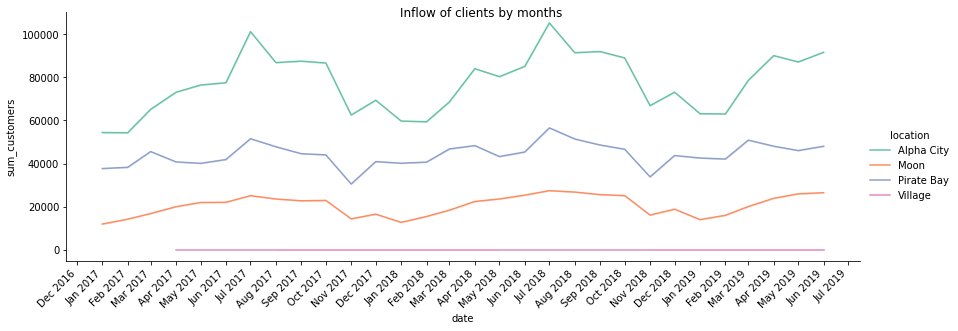

In [252]:
graph = sns.relplot(data=df_merge
      , x="date", y="sum_customers"
      , hue="location", kind="line", palette=colors_ira
      , height=4, aspect=3, facet_kws=dict(sharex=False))

graph.ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
graph.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(graph.ax.get_xticklabels(), rotation=45, ha="right")
graph.fig.suptitle('Inflow of clients by months');

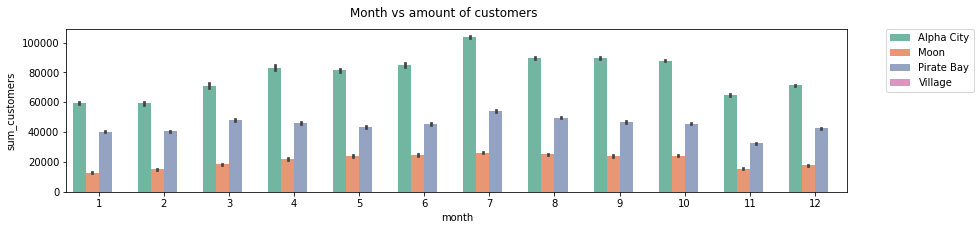

In [253]:
fsize = (14, 3)
fig, ax = plt.subplots(figsize=fsize)
fig.suptitle('Month vs amount of customers')
sns.barplot(data=df_merge, x='month', y='sum_customers'
          , hue='location', palette=colors_ira);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Наблюдается сезонность по потоку клиентов, годовой пик приходится на июль.  
Самый посещаемый город это Alpha City

Зависимость общих продаж от потока клиентов:

Т.к. поток клиентов в разы больше продаж то чтобы данные читались на графике нормализую их.

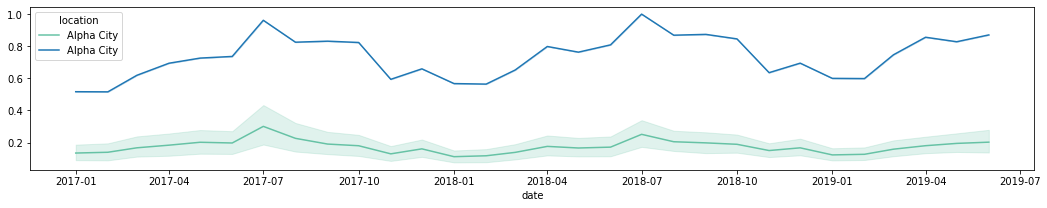

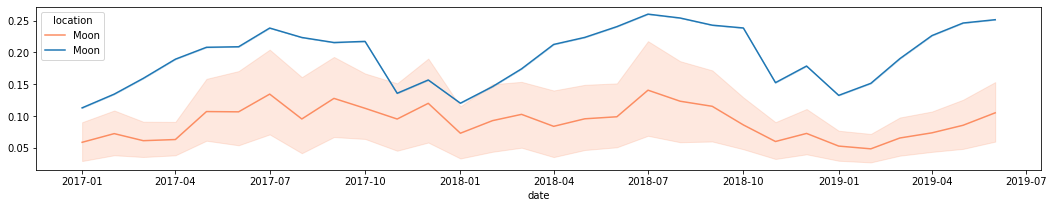

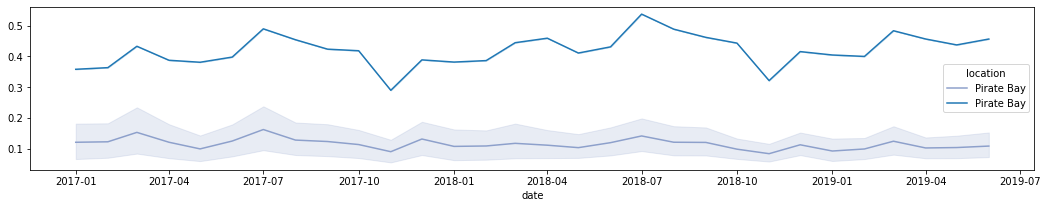

In [254]:
scaler_cust = MinMaxScaler(feature_range=(0, 1))
scaler_vol = MinMaxScaler(feature_range=(0, 1))

scaler_cust = scaler_cust.fit(df_merge['sum_customers'].values.reshape(-1, 1))
scaler_vol = scaler_vol.fit(df_merge['volume'].values.reshape(-1, 1))

for loc in df_merge[df_merge['location'] != 'Village']['location'].unique():    
    data=df_merge[df_merge['location']==loc]    
    sum_customers_scale = scaler_cust.transform(data['sum_customers']\
                                                .values.reshape(-1, 1))
    volume_scale = scaler_vol.transform(data['volume'].values.reshape(-1, 1))
  
    fsize = (18, 3)
    fig, ax = plt.subplots(figsize=fsize)
    sns.lineplot(data=data, x='date', y=volume_scale.ravel()\
                    , hue='location', palette=colors_ira);
    sns.lineplot(data=data, x='date', y=sum_customers_scale.ravel()\
                    , hue='location');

Наблюдается практически линейная зависимость суммарных объемов продаж всех товаров с потоком клиентов.

### Подбор предикторов для товаров у которых есть все данные по продажам с 2017 по 2019

In [255]:
def smape(A, F):
    #Симметричная средняя абсолютная ошибка в процентах
    return np.round(100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))),2)

#### Base Line

Возьму товар у которого есть данные за весь период и отработаю методику на нем

#### Для примера возьму sku #79 and Alpha City

In [333]:
df_ac_sku79 = df_merge[(df_merge['sku_id']=='sku #79') \
                     & (df_merge['ira'] == 'AC')].sort_values(by='date')

In [334]:
df_ac_sku79['month_num'] = range(0, df_ac_sku79.shape[0])

In [335]:
def show_sku_graphical_analysis(data, sku_id, location, colors_sku=colors_sku):
    fsize = (18, 10)
    fig = plt.figure(constrained_layout=True, figsize=fsize)
    #plt.title('{} in {}\'.format(sku_id, location))
    gs = fig.add_gridspec(2, 3)

    fig_ax1 = fig.add_subplot(gs[0, :])
    fig_ax1.grid(alpha=0.25)
    fig_ax1.set_title('Volume in {} and AFC'.format(location))
    sns.lineplot(data=data, x='month_num', y='volume', color=colors_sku[sku_id], ax=fig_ax1)
    sns.regplot(data=data, x='month_num', y='volume', scatter=False, color='black', ax=fig_ax1)
    fig_ax1.set_xticks(data['month_num'])
    fig_ax1.set_xlabel('month - 1 (lags)')
    fig_ax1.set_ylabel('volume')
    fig_ax1_2 = fig_ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plot_acf(data['volume'], lags=data['month_num'].max(), ax=fig_ax1_2, title='')
    fig_ax1_2.set_ylabel('correlations');

    fig_ax2 = fig.add_subplot(gs[1, :-1])
    fig_ax2.set_title('Volume in month')
    sns.barplot(data=data, x='month', y='volume', color=colors_sku[sku_id], ax=fig_ax2);

    fig_ax3 = fig.add_subplot(gs[1:, -1])
    fig_ax2.set_title('Correlation customers and volume')
    sns.scatterplot(data=data, x='sum_customers', y='volume', color=colors_sku[sku_id], ax=fig_ax3);


Графическое представление временного ряда по 'sku #79' и 'Alpha City'

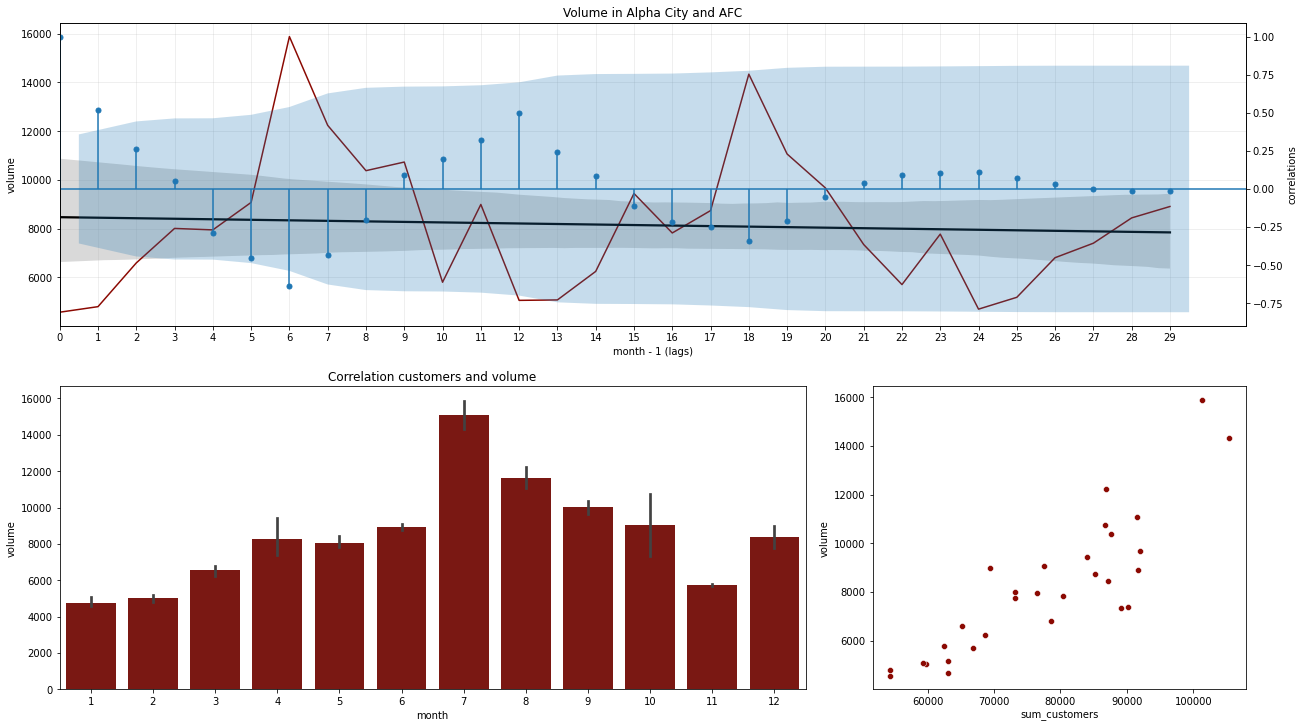

In [336]:
show_sku_graphical_analysis(df_ac_sku79, 'sku #79', 'Alpha City', colors_sku=colors_sku)

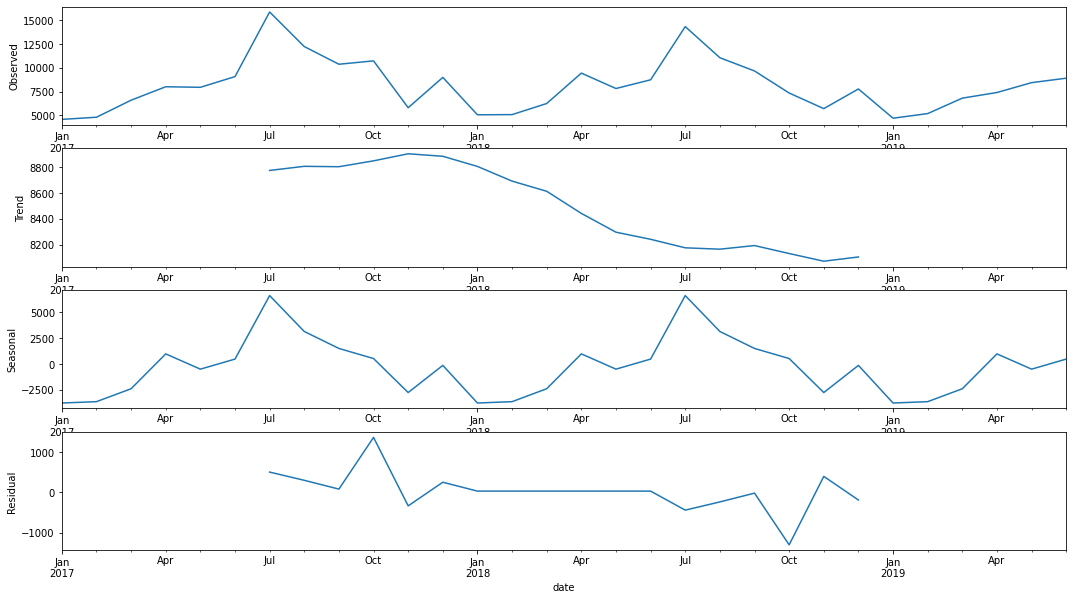

In [337]:
fsize = (18, 10)
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=fsize)
res_ac_sku79 = seasonal_decompose(x=df_ac_sku79.pivot_table(index='date'
                                                            , values='volume')
                                  , model='additive')
res_ac_sku79.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
res_ac_sku79.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
res_ac_sku79.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
res_ac_sku79.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual');

Критерий Дики-Фуллера:

In [338]:
X = df_ac_sku79['volume'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.882300
p-value: 0.000038
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636


У нас есть как сезонность так и тренд (убывающий), но критерий Дики-Фуллера говорит о том, что мы можем отвергнуть нулевую гипотезу  с уровнем значимости менее 1% о том что ряд не стационарен.

In [339]:
X = df_ac_sku79[['sum_customers']]
y = df_ac_sku79['volume']

In [340]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=49, shuffle=False)

#### Модель авторегрессии

In [341]:
ar_fited = AR(y.values).fit()
print('Lag: %s' % ar_fited.k_ar)
print('Coefficients: %s' % ar_fited.params)

Lag: 9
Coefficients: [ 7.94626245e+03  4.32959542e-02  5.14434747e-02  3.35513123e-01
 -1.64708269e-01  9.29208076e-03 -4.50171560e-01 -9.14425004e-02
 -8.94597304e-02  3.75038690e-01]


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


In [342]:
# make predictions
y_pred = ar_fited.predict(start=12, end=len(y)+12-1, dynamic=False)
#for i in range(len(y_pred)):
#    print('predicted=%f, expected=%f' % (y_pred[i], y.values[i]))
#error = mean_squared_error(test, predictions)
error = smape(y, y_pred)
print('Train SMAPE: %.3f' % error)

Train SMAPE: 13.750


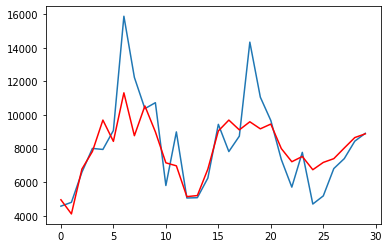

In [343]:
# plot results
plt.plot(y.values)
plt.plot(y_pred, color='red')
plt.show()

In [344]:
autoreg_fitted = AutoReg(y.values, 1, old_names=False).fit()
print(autoreg_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   30
Model:                     AutoReg(1)   Log Likelihood                -265.513
Method:               Conditional MLE   S.D. of innovations           2290.882
Date:                Mon, 15 Feb 2021   AIC                             15.680
Time:                        08:14:20   BIC                             15.822
Sample:                             1   HQIC                            15.725
                                   30                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4066.6081   1311.611      3.100      0.002    1495.897    6637.319
y.L1           0.5184      0.153      3.398      0.001       0.219       0.817
                                    Roots           

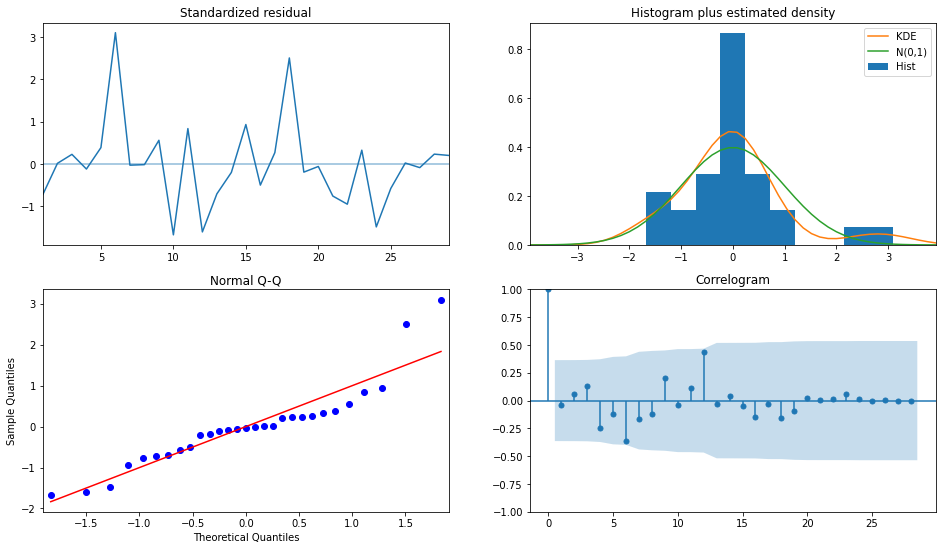

In [345]:
fig = plt.figure(figsize=(16,9))
fig = autoreg_fitted.plot_diagnostics(lags=28, fig=fig)

In [346]:
y_pred = autoreg_fitted.predict(start=0, end=len(y), dynamic=False)

In [347]:
error = smape(y, y_pred)
print('Train SMAPE: %.3f' % error)

Train SMAPE: 13.440


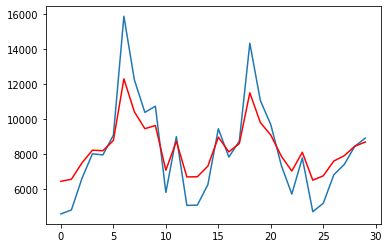

In [348]:
# plot results
plt.plot(y.values)
plt.plot(y_pred, color='red')
plt.show()

#### Линейная регрессия

Регрессивные инструменты не очень хороши для прогнозирование временных рядов, есть инструменты лучше, например ARIMA, экспоненциальное сглаживание, нейронные сети, XGBoost. Но зачастую данных для обучения мало (1,5-2 года) а если есть много данных (10лет), то как правило старые данные уже не подходят потому что у нас в экономике быстро все меняется. Вот как раз эти лучшие инструменты не работают с такими короткими рядами а регрессивные модели могут.

#### Base line:

In [349]:
def fit_linear_regression(X, y, plot=True, scale=True):
    '''
    Обучение линейной регрессии, вывод результата и возврат обученной модели
    '''
    if (scale):
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    lr_fitted = LinearRegression().fit(X, y)
    y_pred = lr_fitted.predict(X)
    print('LinearRegression\nTrain SMAPE: {}\n'.format(smape(y, y_pred)))
    
    if (plot):
        fsize = (10, 4)
        fig, ax = plt.subplots(figsize=fsize)
        ax.grid(alpha=0.25)
        ax.set_xticks(range(1,X.shape[0]+1))
        ax.set_xlabel('month')
        ax.set_ylabel('volume')
        
        plt.plot(y.values)
        plt.plot(y_pred, color='red')
        plt.show()
    return lr_fitted

 - Приток клиентов

In [350]:
X = df_ac_sku79[['sum_customers']]

In [351]:
y = df_ac_sku79['volume']

LinearRegression
Train SMAPE: 12.02



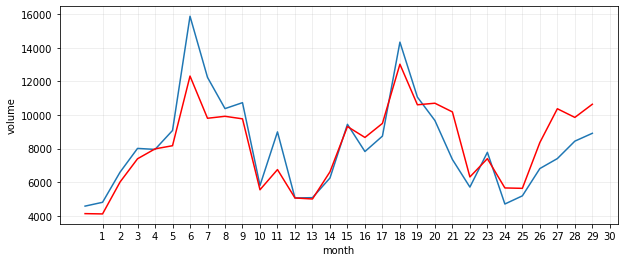

In [352]:
lr_fitted = fit_linear_regression(X, y, scale=False)

В бейзлайне я использовал общую сумму притока клиентов, можно рассмотреть каждый тип клиента как отдельный признак

Посмотрим на корреляцию признаков:

In [353]:
def get_correlation (data, figsize=(11, 9), use_abs=True):
    '''
    График корреляции признаков
    '''
    corr = data.corr()
    if (use_abs):
        corr = np.abs(data.corr()) #берем абсолютные значения
        print('Использованы абсолютные значения корреляции.')

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fif, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr,cmap=cmap, square=True,linewidths=.5
              , mask=mask,annot=True, fmt=".1f")

Использованы абсолютные значения корреляции.


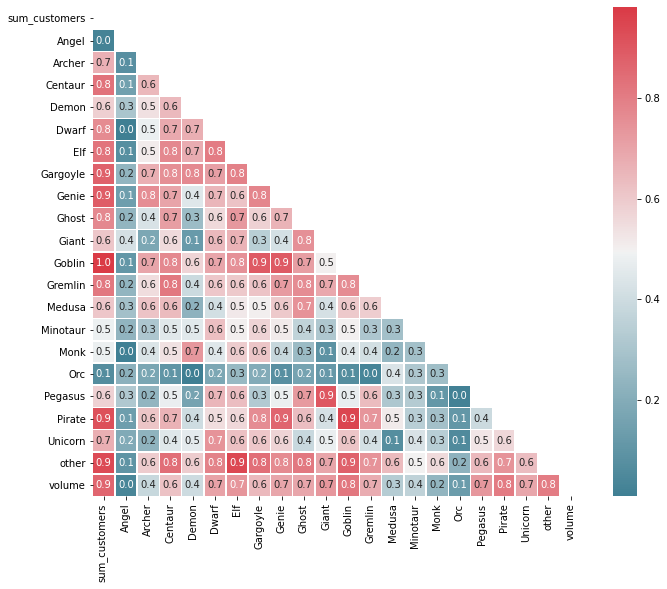

In [354]:
get_correlation(df_ac_sku79[['sum_customers', 'Angel', 'Archer', 'Centaur'
            ,'Demon', 'Dwarf','Elf', 'Gargoyle', 'Genie', 'Ghost', 'Giant'
            ,'Goblin', 'Gremlin','Medusa', 'Minotaur', 'Monk', 'Orc'
            ,'Pegasus','Pirate', 'Unicorn','other','volume']])

Видно, что с целевой переменной volume достаточно сильная корреляция у ряда признаков, так же у 'sum_customers' и 'Goblin' нужно из них оставить только одну. Остальные признаки тоже имеют достаточно сильную корреляцию между собой, а линейная регрессия не любить коллинеарность.

In [355]:
col_names = ['other', 'Archer', 'Centaur','Demon', 'Dwarf', 'Elf'\
        ,'Angel','Gargoyle', 'Genie', 'Ghost', 'Giant','Goblin', 'Gremlin'\
        ,'Medusa', 'Minotaur', 'Monk', 'Orc', 'Pegasus','Pirate', 'Unicorn']

In [356]:
X = df_ac_sku79[col_names]

Масштаб у них один и тот же, поэтому дополнительно масштабировать данные нет смысла

LinearRegression
Train SMAPE: 4.69



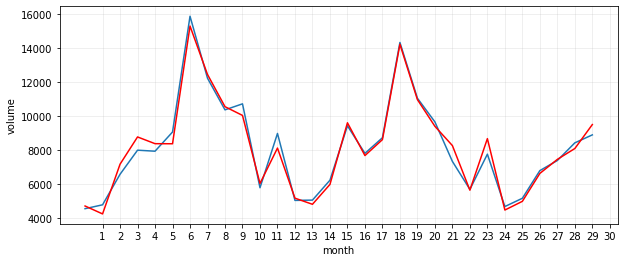

In [357]:
lr_fitted = fit_linear_regression(X, y, scale=False)

Стало на много лучше!

Посмотрим на коэффициенты модели

In [358]:
def get_coefs_lr(lr_fitted, data_columns):
    '''
    Выводит на экран признаки и коэффициенты линейной регрессии
    '''
    for coef, col in sorted(zip(lr_fitted.coef_, data_columns)
                            , key=lambda x: np.abs(x[0])):
        print("{} \t {}".format(np.round(coef, 4), col))

In [359]:
get_coefs_lr(lr_fitted, col_names)

-0.103 	 Genie
-0.1541 	 Orc
0.2557 	 Pirate
-0.3616 	 Medusa
0.5223 	 Elf
-0.5607 	 Demon
-0.7301 	 other
-1.142 	 Unicorn
1.461 	 Giant
1.6013 	 Centaur
-1.6139 	 Gargoyle
2.017 	 Monk
2.1436 	 Dwarf
-3.7483 	 Angel
-4.0908 	 Ghost
-4.3277 	 Gremlin
-5.4134 	 Minotaur
6.0493 	 Pegasus
-8.5376 	 Archer
15.081 	 Goblin


У Goblin самый большой коэффициент, а значит самое большое влияние на предсказание.  
"Космических" значений у признаков нет, значит нет влияния коллинеарности.

 - Сглаженный коэффициент продажи по месяцам

Выведу коэффициент продажи по месяцам. Возьму средние продажи за каждый месяц и приведу к масштабу от 0 до 1, т.о. коэффициент самого продаваемого месяца будет 1 а остальные будет относительно него меньше. Коэффициент будет отражать некую сезонность.

In [360]:
_ = df_ac_sku79.groupby('month').sum()[['volume','item_per_bundle']]
_

volume  item_per_bundle
month                          
1      14328.0                3
2      15060.0                3
3      19650.0                3
4      24858.0                3
5      24216.0                3
6      26730.0                3
7      30222.0                2
8      23304.0                2
9      20052.0                2
10     18084.0                2
11     11508.0                2
12     16770.0                2

In [361]:
# найду средние продажи в месяц и нормализую
min_max_scaler = MinMaxScaler()
_ = min_max_scaler.fit_transform(pd.DataFrame(_['volume'] 
                                            / _['item_per_bundle']))
_

array([[0.        ],
       [0.0236091 ],
       [0.17164973],
       [0.33962264],
       [0.3189163 ],
       [0.4       ],
       [1.        ],
       [0.66531205],
       [0.50798258],
       [0.41277213],
       [0.0946299 ],
       [0.34920174]])

In [362]:
month_volume_coefs = {i+1: np.round(value[0],3) for (i, value) in enumerate(_)}
month_volume_coefs

{1: 0.0,
 2: 0.024,
 3: 0.172,
 4: 0.34,
 5: 0.319,
 6: 0.4,
 7: 1.0,
 8: 0.665,
 9: 0.508,
 10: 0.413,
 11: 0.095,
 12: 0.349}

In [363]:
#Подготовлю новый столбец где будет указан исторический коэффициент продаж в календарный месяц
df_ac_sku79['month_volume_coef'] = df_ac_sku79['month'].map(month_volume_coefs)

In [364]:
col_names = ['other', 'Archer', 'Centaur','Demon', 'Dwarf', 'Elf'\
        ,'Angel','Gargoyle', 'Genie', 'Ghost', 'Giant','Goblin', 'Gremlin'\
        ,'Medusa', 'Minotaur', 'Monk', 'Orc', 'Pegasus','Pirate', 'Unicorn'\
        ,'month_volume_coef']

In [365]:
X = df_ac_sku79[col_names]

Нужно привести данные к единому масштабу, т.к. шкалы отличаются

LinearRegression
Train SMAPE: 3.98



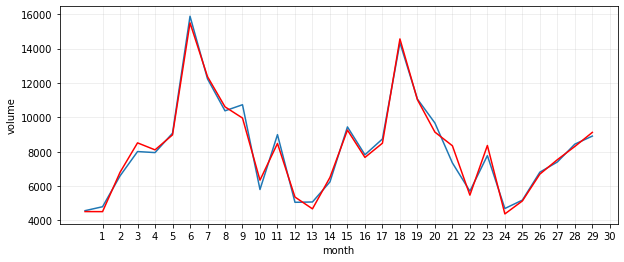

In [366]:
lr_fitted = fit_linear_regression(X, y, scale=True)

In [367]:
get_coefs_lr(lr_fitted, col_names)

-50.1307 	 Medusa
-61.8037 	 Giant
134.4885 	 Genie
-163.967 	 Orc
-222.0311 	 Ghost
-246.8012 	 Unicorn
253.3638 	 Elf
-273.5319 	 Minotaur
-310.0108 	 Archer
-445.2443 	 Angel
-461.3333 	 Gremlin
493.9712 	 Pegasus
593.4956 	 Monk
599.2731 	 Centaur
-633.7353 	 Gargoyle
648.5524 	 Dwarf
-853.3912 	 Demon
-1149.0094 	 Pirate
-1168.1324 	 other
2461.8134 	 month_volume_coef
2652.533 	 Goblin


!!! Коэффициенты заметно выросли, month_volume_coef и Goblin, больше всех оказывают влияние на прогноз

В целом стало не сильно лучше, видимо потому что данные по притоку клиентов уже отражают сезонность, но тем не менее некоторые пики стали обрабатываться моделью лучше

 - Другие коэффициенты продаж

Цепной прирост (chain_growth) = продажи в текущем месяце минум продажи в предыдущем

Коэффициент роста цепной (chain_growth_rate) = продажи текущего месяца разделить на продажи предыдущего

!!! Добавить Среднегодовой спрос = разница между средним спросом(продажами) за год и текущими продажами

In [368]:
chain_growth = []
chain_growth_rate = []

for i, idx in enumerate(df_ac_sku79.index):
    cur_volume = df_ac_sku79.loc[idx]['volume']
    if 0 == i:
        previous = cur_volume
    chain_growth.append(cur_volume - previous)
    chain_growth_rate.append(cur_volume/previous)
    previous = cur_volume

In [369]:
df_ac_sku79['chain_growth'] = chain_growth
df_ac_sku79['chain_growth_rate'] = chain_growth_rate

Данные коэффициенты нужно сгладить по месяцам, вычислить средний в каждый месяц, чтобы можно было использовать для данных которые мы будем прогнозировать на 3 мес вперед

In [370]:
df_ac_sku79_coefs = df_ac_sku79.pivot_table(index='month'
                      , values=['chain_growth', 'chain_growth_rate']
                      , aggfunc={'mean'})
df_ac_sku79_coefs

chain_growth chain_growth_rate
              mean              mean
month                               
1          -2338.0          0.722181
2            244.0          1.052292
3           1530.0          1.305968
4           1736.0          1.271324
5           -214.0          0.987055
6            838.0          1.104885
7           6201.0          1.694931
8          -3459.0          0.771116
9          -1626.0          0.861113
10          -984.0          0.897015
11         -3288.0          0.658426
12          2631.0          1.456466

In [371]:
chain_growth_coefs = {i+1: np.round(value,1) for (i, value) in enumerate(df_ac_sku79_coefs[df_ac_sku79_coefs.columns[0]].values)}
chain_growth_coefs

{1: -2338.0,
 2: 244.0,
 3: 1530.0,
 4: 1736.0,
 5: -214.0,
 6: 838.0,
 7: 6201.0,
 8: -3459.0,
 9: -1626.0,
 10: -984.0,
 11: -3288.0,
 12: 2631.0}

In [372]:
chain_growth_rate_coefs = {i+1: np.round(value,4) for (i, value) in enumerate(df_ac_sku79_coefs[df_ac_sku79_coefs.columns[1]].values)}
chain_growth_rate_coefs

{1: 0.7222,
 2: 1.0523,
 3: 1.306,
 4: 1.2713,
 5: 0.9871,
 6: 1.1049,
 7: 1.6949,
 8: 0.7711,
 9: 0.8611,
 10: 0.897,
 11: 0.6584,
 12: 1.4565}

In [373]:
#Подготовлю новые столбцы где будет указан сглаженные коэффициенты продаж
df_ac_sku79['chain_growth_rate_avg'] = df_ac_sku79['month'].map(chain_growth_rate_coefs)
df_ac_sku79['chain_growth_avg'] = df_ac_sku79['month'].map(chain_growth_coefs)

Прибавлю новые коэффициенты к сезонности

In [374]:
col_names = ['chain_growth_avg', 'chain_growth_rate_avg', 'month_volume_coef']

In [375]:
X = df_ac_sku79[col_names]

In [376]:
X.corr()

chain_growth_avg  chain_growth_rate_avg  \
chain_growth_avg               1.000000               0.978035   
chain_growth_rate_avg          0.978035               1.000000   
month_volume_coef              0.450183               0.456584   

                       month_volume_coef  
chain_growth_avg                0.450183  
chain_growth_rate_avg           0.456584  
month_volume_coef               1.000000

LinearRegression
Train SMAPE: 5.06



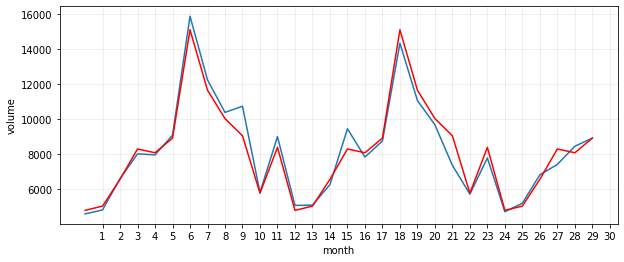

In [377]:
lr_fitted = fit_linear_regression(X, y, scale=True)

In [378]:
get_coefs_lr(lr_fitted, col_names)

1.546 	 chain_growth_rate_avg
-2.3902 	 chain_growth_avg
2675.4858 	 month_volume_coef


Результат то получается не сильно хуже когда мы использовали только аналитические данные стронней компании, там SMAPE был 3.98 против 5.06 сейчас. Только видно, что модель не учитывает тренд, прогноз по сути такой же как в прошлом году, т.е. средний за 2 года, нужно подмать над учетом тренда.

 - Совмещу эти признаки с данными аналитической компании

In [379]:
col_names = ['other', 'Archer', 'Centaur','Demon', 'Dwarf', 'Elf'\
        ,'Angel','Gargoyle', 'Genie', 'Ghost', 'Giant','Goblin', 'Gremlin'\
        ,'Medusa', 'Minotaur', 'Monk', 'Orc', 'Pegasus','Pirate', 'Unicorn'\
        ,'chain_growth_avg', 'chain_growth_rate_avg', 'month_volume_coef']

In [380]:
X = df_ac_sku79[col_names]

LinearRegression
Train SMAPE: 2.69



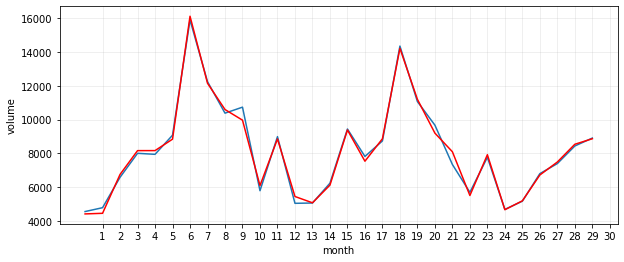

In [381]:
lr_fitted = fit_linear_regression(X, y, scale=True)

 - Коэффициенты связанные с потоком клиентов

month_growth - Отношение продаж текущего месяца к продажам в этом месяце в прошлом году в процентах

month_growth_cmltv_year_perc - нарастающий итог month_growth за год

month_growth_cmltv_year_perc_mean - month_growth_cmltv_year_perc

In [382]:
# Новый столбец - отношение продаж текущего месяца к продажам в этом месяце в прошлом году
df_ac_sku79['customer_growth_perc'] = 100
# Куммулятивное отношение customer_growth_perc, нарастающий итог за год
df_ac_sku79['customer_growth_cmltv_year_perc'] = 0
# Средний кумулятивный нарастающий итог за год
df_ac_sku79['customer_growth_cmltv_year_perc_mean'] = 0

for year in [2019, 2018]:
    curr_year = df_ac_sku79[df_ac_sku79['year'] == year]
    last_year = df_ac_sku79[df_ac_sku79['year'] == year-1]
    last_customer_growth_cmltv_year_perc = 0
    curr_customer_growth_cmltv_year_perc = 0
    iter = 1
    for idx, row in curr_year.iterrows():
        curr_customer_growth_perc = int((row['sum_customers'] / last_year[last_year['month'] == row['month']]['sum_customers']) * 100)
        df_ac_sku79.at[idx, 'customer_growth_perc'] = curr_customer_growth_perc
   
        if (iter > 1):         
            curr_customer_growth_cmltv_year_perc = curr_customer_growth_perc + last_customer_growth_cmltv_year_perc    
        df_ac_sku79.at[idx, 'customer_growth_cmltv_year_perc'] = curr_customer_growth_cmltv_year_perc
        df_ac_sku79.at[idx, 'customer_growth_cmltv_year_perc_mean'] = curr_customer_growth_cmltv_year_perc / iter

        last_customer_growth_cmltv_year_perc = curr_customer_growth_cmltv_year_perc
        iter+=1

In [383]:
df_ac_sku79[['customer_growth_perc', 'customer_growth_cmltv_year_perc', 'customer_growth_cmltv_year_perc_mean', 'sum_customers']].corr()

customer_growth_perc  \
customer_growth_perc                              1.000000   
customer_growth_cmltv_year_perc                   0.330490   
customer_growth_cmltv_year_perc_mean              0.633110   
sum_customers                                     0.059719   

                                      customer_growth_cmltv_year_perc  \
customer_growth_perc                                          0.33049   
customer_growth_cmltv_year_perc                               1.00000   
customer_growth_cmltv_year_perc_mean                          0.86139   
sum_customers                                                 0.36912   

                                      customer_growth_cmltv_year_perc_mean  \
customer_growth_perc                                              0.633110   
customer_growth_cmltv_year_perc                                   0.861390   
customer_growth_cmltv_year_perc_mean                              1.000000   
sum_customers                                                     0.416112   

                                      sum_customers  
customer_growth_perc                       0.059719  
customer_growth_cmltv_year_perc            0.369120  
customer_growth_cmltv_year_perc_mean       0.416112  
sum_customers                              1.000000

Добавлю эти фичи в модель

In [384]:
col_names = ['other', 'Archer', 'Centaur','Demon', 'Dwarf', 'Elf'\
        ,'Angel','Gargoyle', 'Genie', 'Ghost', 'Giant','Goblin', 'Gremlin'\
        ,'Medusa', 'Minotaur', 'Monk', 'Orc', 'Pegasus','Pirate', 'Unicorn'\
        ,'chain_growth_avg', 'chain_growth_rate_avg', 'month_volume_coef'\
        ,'customer_growth_perc', 'customer_growth_cmltv_year_perc'\
        , 'customer_growth_cmltv_year_perc_mean']

In [385]:
X = df_ac_sku79[col_names]

In [386]:
#Пока убрал, т.к. не проработал как добавить эти коэффициенты в новые данные на основании которых будут предсказаны 3 мес
#lr_fitted = fit_linear_regression(X, y, scale=True)

#### Предсказание на 3 месяца впред

Подготавливаю предикторы

In [387]:
col_names = ['other', 'Archer', 'Centaur','Demon', 'Dwarf', 'Elf'\
        ,'Angel','Gargoyle', 'Genie', 'Ghost', 'Giant','Goblin', 'Gremlin'\
        ,'Medusa', 'Minotaur', 'Monk', 'Orc', 'Pegasus','Pirate', 'Unicorn'\
        ,'chain_growth_avg', 'chain_growth_rate_avg', 'month_volume_coef']

In [388]:
# Датафремй для предсказания 7,8 и 9 месяца 2019
ira = 'AC'#'PB'

df_ac_sku79_custs789 = pd.DataFrame({'year':[2019]*3
                                   , 'month':[7,8,9]
                                   , 'ira':[ira]*3
                                   , 'volume':[0]*3
                                    })

In [389]:
#Столбец с датой
df_ac_sku79_custs789['date'] = df_ac_sku79_custs789[['year','month']]\
                                    .apply(lambda r: '{}-{}'
                                    .format(r['year'], r['month']), axis=1)

df_ac_sku79_custs789['date'] = pd.to_datetime(df_ac_sku79_custs789['date'])

In [390]:
# Столбец с номером месяца относительно последнего по товару и городу
month_amont_to_predict = 3
month_nums_to_predict = range(df_ac_sku79['month_num'].max()+1
                            , df_ac_sku79['month_num'].max()+1
                              +month_amont_to_predict)

df_ac_sku79_custs789['month_num'] = month_nums_to_predict

In [391]:
#Столбец коэффициент месячных продаж
df_ac_sku79_custs789['month_volume_coef'] = df_ac_sku79_custs789['month']\
                                           .map(month_volume_coefs)

In [392]:
#Столбцы сглаженные коэффициенты продаж
df_ac_sku79_custs789['chain_growth_rate_avg'] = df_ac_sku79_custs789['month']\
                                               .map(chain_growth_rate_coefs)
df_ac_sku79_custs789['chain_growth_avg'] = df_ac_sku79_custs789['month']\
                                          .map(chain_growth_coefs)

In [393]:
#Добавлю данные по потоку клиентов
df_ac_sku79_custs789 = df_ac_sku79_custs789.join(df_custs_amount
                                                 , on=['ira','date'])

In [394]:
# Проверка на пустые значения
df_ac_sku79_custs789.isnull().sum().sum()

0

Предсказание

In [395]:
scaler = StandardScaler()

X = scaler.fit_transform(df_ac_sku79[col_names])
X_new = scaler.transform(df_ac_sku79_custs789[col_names])
y = df_ac_sku79['volume']

lr_fitted = LinearRegression().fit(X, y)

y_pred_train = lr_fitted.predict(X)
y_pred_new = lr_fitted.predict(X_new)

In [396]:
df_ac_sku79_custs789['volume'] = lr_fitted.predict(scaler.transform(df_ac_sku79_custs789[col_names]))

In [397]:
#Объединяю фактические и предсказанные данные по продажам
df_ac_sku79_pred =pd.DataFrame().append([
                         df_ac_sku79[['date','location', 'volume']]
                       , df_ac_sku79_custs789[['date','ira'
                                              , 'volume']]])

In [398]:
def plot_fact_predict(df_sku_fact_pred, y_pred_train, sku_id, city):
    '''
    Рисует фактические данные и прездсказанные на одном графике
    '''
    fsize = (18, 3) 
    fig, ax = plt.subplots(figsize=fsize)
    plt.title('{} in {}. Fact and predictions after 2019-06'\
              .format(sku_id, city))
    data = df_sku_fact_pred[df_sku_fact_pred['date'] <= '2019-06']
    data_pred = df_sku_fact_pred[df_sku_fact_pred['date'] >= '2019-06']
    sns.lineplot(data=data, x='date', y='volume', color=colors_sku[sku_id]);
    sns.lineplot(data=data, x='date', y=y_pred_train, color='blue');
    ax.lines[1].set_linestyle(":")
    sns.lineplot(data=data_pred, x='date', y='volume', color='green');
    sns.scatterplot(data=data_pred[1:], x='date', y='volume', color='red')
    ax.set_xticks(df_sku_fact_pred['date'])
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.grid(alpha=0.25)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right");
    for i, point in data_pred[1:].iterrows():
        ax.text(point['date'], point['volume'], str(int(round(point['volume']
                                                              , 0)))
                                                              , rotation=45)
    
    #Прогнозные значения на 3 мес
    print('\nПрогноз на 3 месяца:\n')
    print(df_sku_fact_pred[df_sku_fact_pred['date'] > '2019-06'][['date', 'volume']])
    plt.show()

In [399]:
get_coefs_lr(lr_fitted, col_names)

-97.2373 	 Pirate
133.353 	 Gargoyle
183.7126 	 Monk
-219.7359 	 Giant
-239.5822 	 Centaur
245.0258 	 Medusa
-305.2726 	 Ghost
-345.7351 	 Orc
399.9197 	 Angel
-414.008 	 Archer
-466.6396 	 Demon
-542.6931 	 Gremlin
-547.2316 	 Minotaur
902.4187 	 Dwarf
976.4042 	 Genie
-1043.668 	 Unicorn
1435.3396 	 Elf
1823.1066 	 Pegasus
2260.6191 	 month_volume_coef
2356.0301 	 Goblin
-3569.2055 	 other
5923.7334 	 chain_growth_avg
-6452.7444 	 chain_growth_rate_avg



Прогноз на 3 месяца:

        date        volume
0 2019-07-01  15302.204326
1 2019-08-01  11713.947800
2 2019-09-01  11896.312685


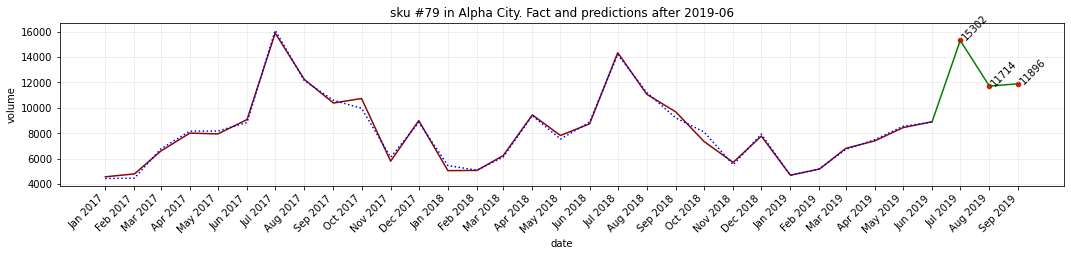


LinearRegression
Train SMAPE: 2.69



In [400]:
plot_fact_predict(df_ac_sku79_pred, y_pred_train, 'sku #79', 'Alpha City')
print('\nLinearRegression\nTrain SMAPE: {}\n'.format(smape(y, y_pred_train)))

На графике анализа товара наблюдался небольшой но понижающий тренд, но предсказания получились немного выше аналогичным продажам прошлого года. Это связано с возросшим потоком клиентов в 2019 году, относительно 2018 и 2017

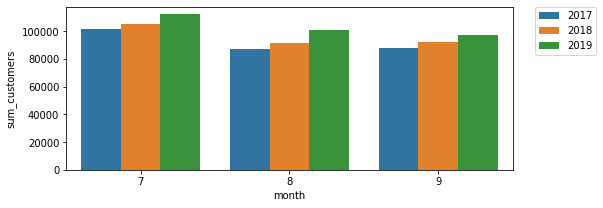

In [401]:
data = pd.concat([
    df_ac_sku79_custs789[['year', 'month', 'sum_customers']]
   ,df_ac_sku79[df_ac_sku79['month'].isin([7,8,9])][['year', 'month', 'sum_customers']]
])
fsize = (8, 3) 
fig, ax = plt.subplots(figsize=fsize)
sns.barplot(data=data, x='month', y='sum_customers', hue='year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### Прогнозирование продаж остальных товаров

#### - Возьму сначала товары, у которых есть данные по продажам с 2017 по 2019 года

In [402]:
# Создам словарь соответствия location и ira
location_dict = {}
for location in df_merge.location.unique():
    ira_for_dict = df_merge[df_merge['location'] == location].head(1).ira.values[0]
    location_dict[location] =  ira_for_dict
location_dict

{'Alpha City': 'AC', 'Moon': 'MN', 'Pirate Bay': 'PB', 'Village': 'VL'}






************== Location: Alpha City(AC) ==************

Товары к прогнозу (15)
['sku #15' 'sku #16' 'sku #22' 'sku #25' 'sku #28' 'sku #30' 'sku #31'
 'sku #38' 'sku #41' 'sku #46' 'sku #48' 'sku #49' 'sku #73' 'sku #78'
 'sku #79']

============sku #15============

ADF Statistic: -3.771535
p-value: 0.003212
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633

LinearRegression
SMAPE: 10.96


Прогноз на 3 месяца:

        date        volume
0 2019-07-01  10472.768382
1 2019-08-01  10497.394676
2 2019-09-01  18108.146871


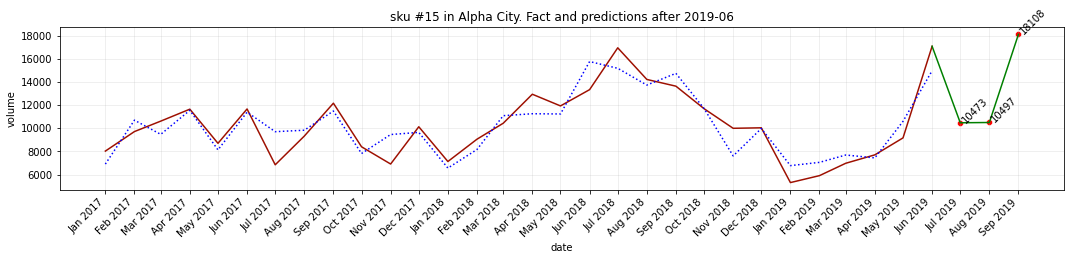


============sku #16============

ADF Statistic: -3.437313
p-value: 0.009751
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651

LinearRegression
SMAPE: 3.78


Прогноз на 3 месяца:

        date        volume
0 2019-07-01  11885.927641
1 2019-08-01   8014.769109
2 2019-09-01   4902.983118


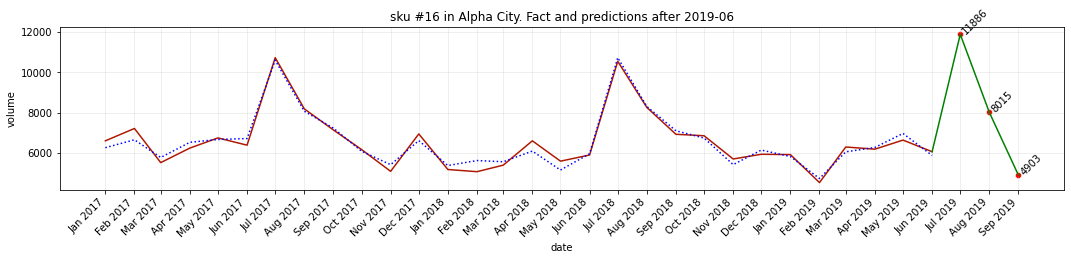


============sku #22============

ADF Statistic: -2.696120
p-value: 0.074712
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646

LinearRegression
SMAPE: 3.37


Прогноз на 3 месяца:

        date        volume
0 2019-07-01  23452.695528
1 2019-08-01  21096.805687
2 2019-09-01  26170.559850


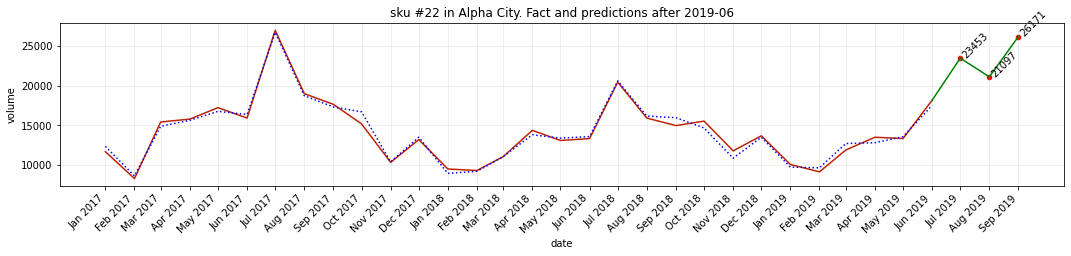


============sku #25============

ADF Statistic: -0.574283
p-value: 0.876688
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646

LinearRegression
SMAPE: 1.78


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  9380.654131
1 2019-08-01  6198.602722
2 2019-09-01  7416.377937


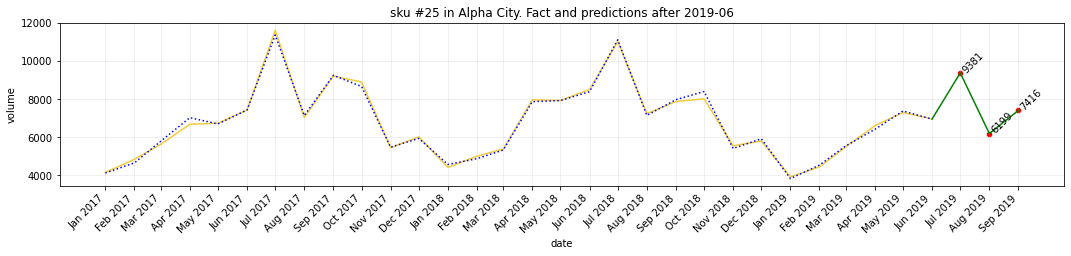


============sku #28============

ADF Statistic: -3.857993
p-value: 0.002367
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 2.6


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  5593.510022
1 2019-08-01  5439.483317
2 2019-09-01  5862.034469


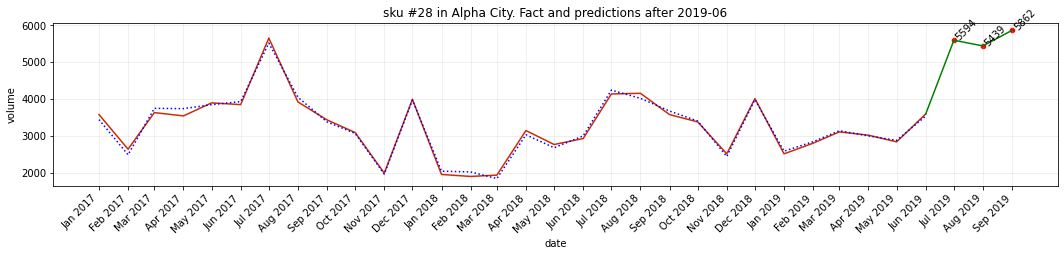


============sku #30============

ADF Statistic: -3.906461
p-value: 0.001988
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 7.98


Прогноз на 3 месяца:

        date        volume
0 2019-07-01  24986.944413
1 2019-08-01  11860.350011
2 2019-09-01   4189.727409


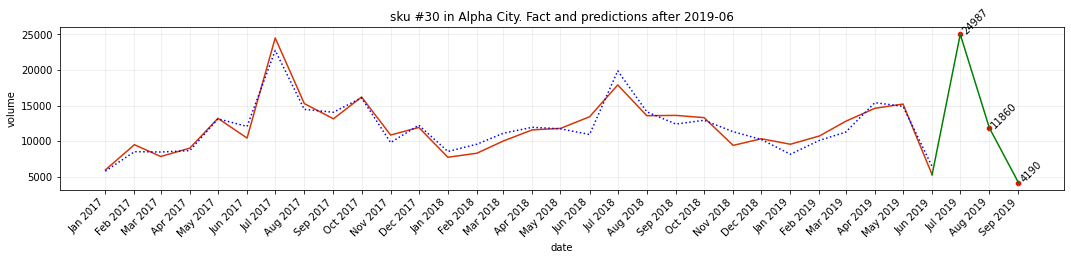


============sku #31============

ADF Statistic: -0.907708
p-value: 0.785423
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 7.76


Прогноз на 3 месяца:

        date       volume
0 2019-07-01   986.788973
1 2019-08-01  1016.217167
2 2019-09-01   877.391116


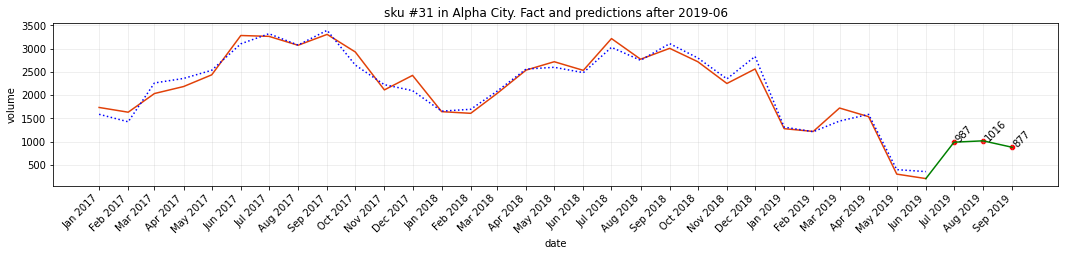


============sku #38============

ADF Statistic: -2.662135
p-value: 0.080823
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 8.07


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  2171.876260
1 2019-08-01  2223.564701
2 2019-09-01  3830.839601


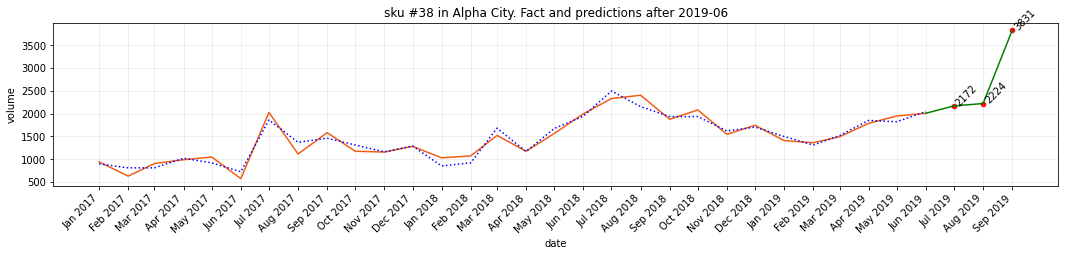


============sku #41============

ADF Statistic: -3.768467
p-value: 0.003247
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651

LinearRegression
SMAPE: 11.67


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  5834.849361
1 2019-08-01  4482.688569
2 2019-09-01  8369.870855


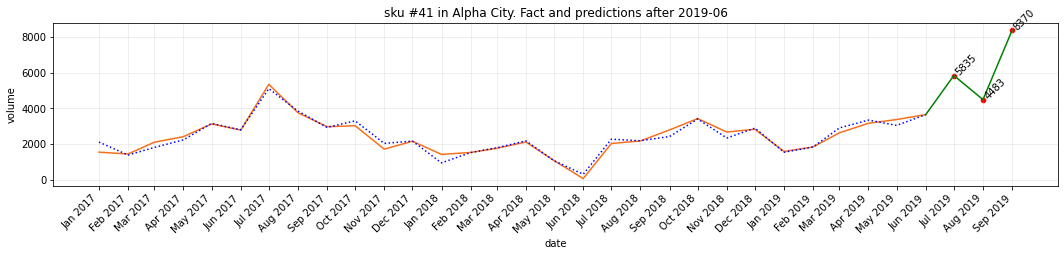


============sku #46============

ADF Statistic: 0.187639
p-value: 0.971560
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639

LinearRegression
SMAPE: 3.56


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  5914.493264
1 2019-08-01  5300.801700
2 2019-09-01  5941.029857


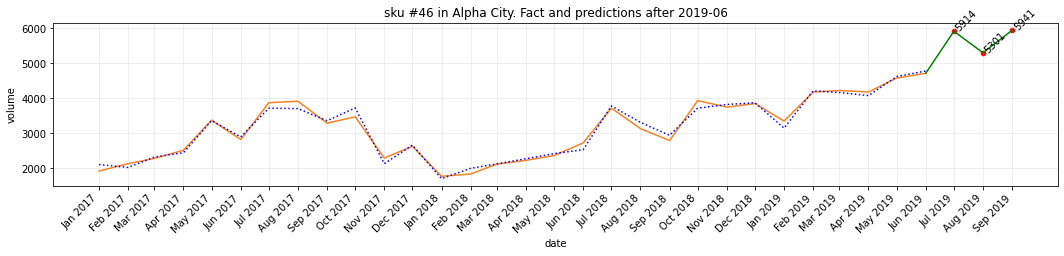


============sku #48============

ADF Statistic: -4.104282
p-value: 0.000953
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636

LinearRegression
SMAPE: 2.6


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  9336.700839
1 2019-08-01  7737.091531
2 2019-09-01  7671.936269


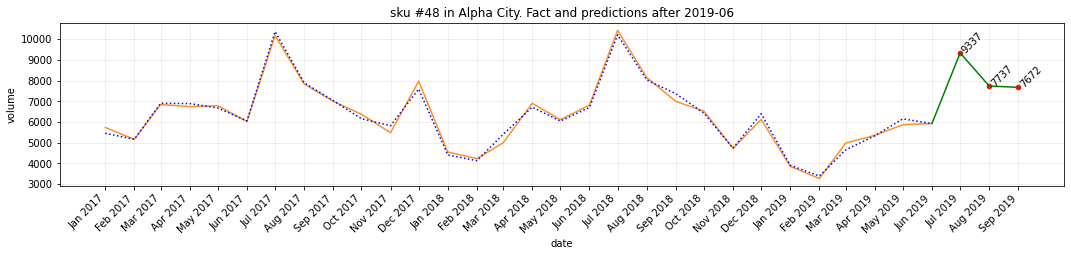


============sku #49============

ADF Statistic: -0.602947
p-value: 0.870315
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651

LinearRegression
SMAPE: 4.14


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  2960.308433
1 2019-08-01  3530.627968
2 2019-09-01  4371.075565


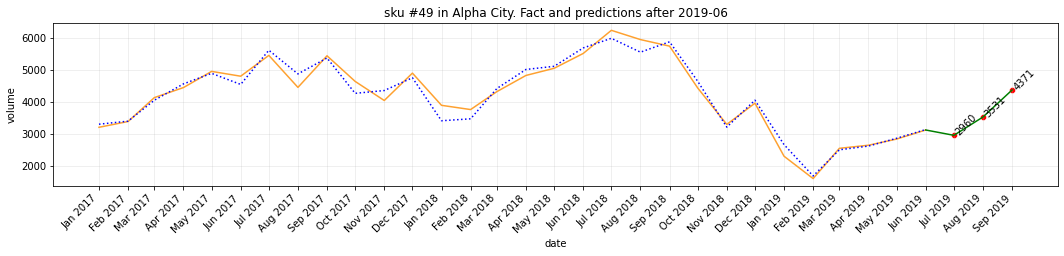


============sku #73============

ADF Statistic: -1.165798
p-value: 0.688133
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651

LinearRegression
SMAPE: 1.15


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  6025.523666
1 2019-08-01  3715.511632
2 2019-09-01  5380.740703


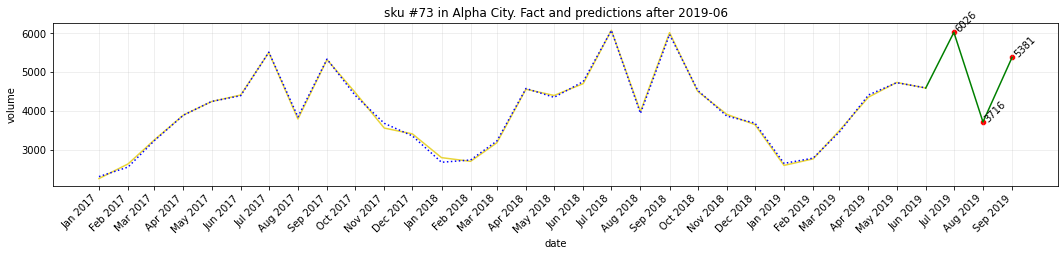


============sku #78============

ADF Statistic: -4.202928
p-value: 0.000651
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 11.14


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  8873.030055
1 2019-08-01  6177.605303
2 2019-09-01  7855.727590


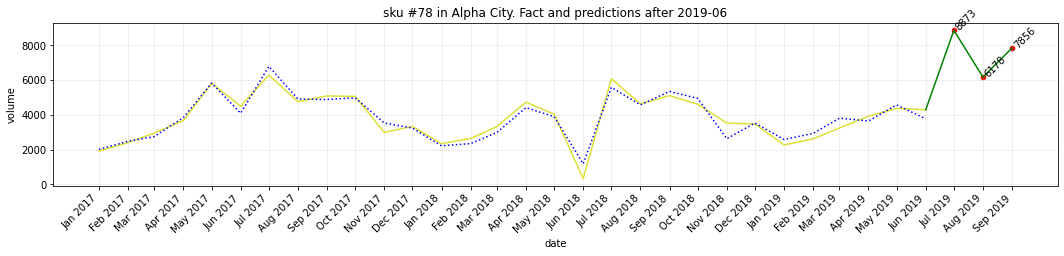


============sku #79============

ADF Statistic: -4.882300
p-value: 0.000038
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636

LinearRegression
SMAPE: 2.69


Прогноз на 3 месяца:

        date        volume
0 2019-07-01  15302.204326
1 2019-08-01  11713.947800
2 2019-09-01  11896.312685


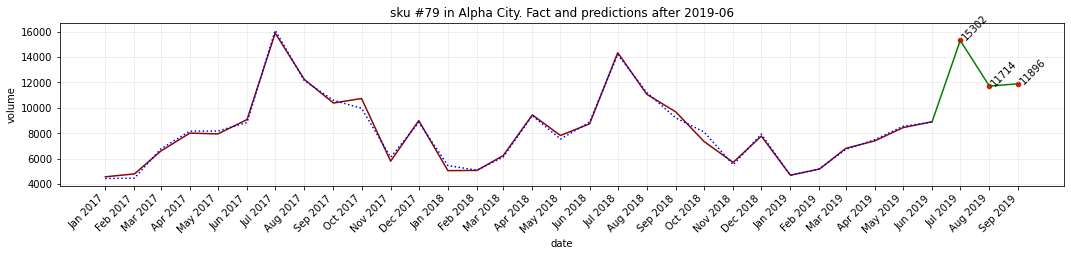






************== Location: Moon(MN) ==************

Товары к прогнозу (0)
[]





************== Location: Pirate Bay(PB) ==************

Товары к прогнозу (14)
['sku #15' 'sku #16' 'sku #22' 'sku #25' 'sku #28' 'sku #30' 'sku #38'
 'sku #42' 'sku #46' 'sku #48' 'sku #49' 'sku #67' 'sku #73' 'sku #79']

============sku #15============

ADF Statistic: -1.086748
p-value: 0.720328
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 15.81


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  3961.770821
1 2019-08-01  7916.825420
2 2019-09-01  2378.660392


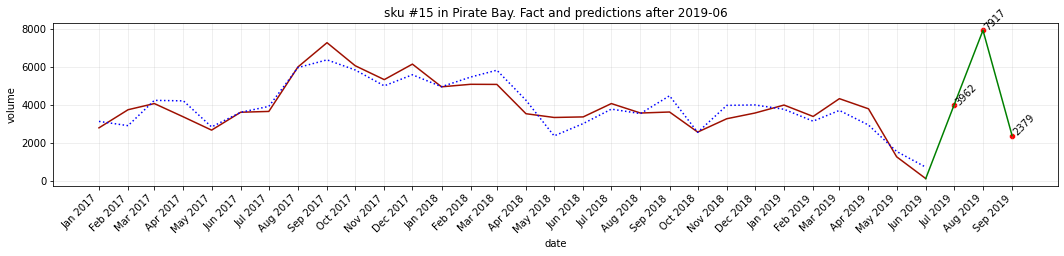


============sku #16============

ADF Statistic: -1.617060
p-value: 0.474271
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633

LinearRegression
SMAPE: 3.07


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  8862.986885
1 2019-08-01  3765.201174
2 2019-09-01  6089.740845


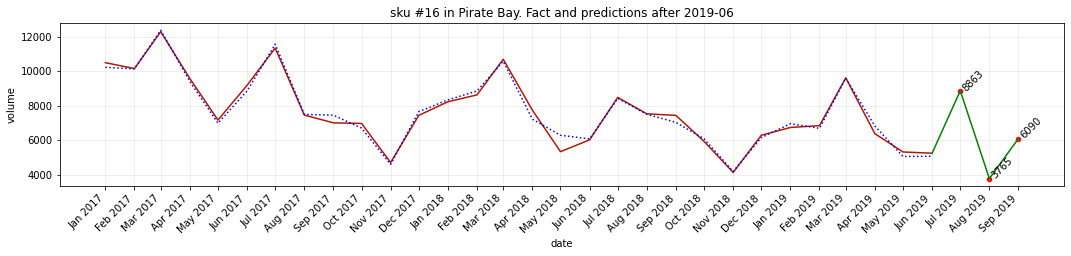


============sku #22============

ADF Statistic: -4.778277
p-value: 0.000060
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 4.58


Прогноз на 3 месяца:

        date        volume
0 2019-07-01  14353.580165
1 2019-08-01  15003.870990
2 2019-09-01  11209.361055


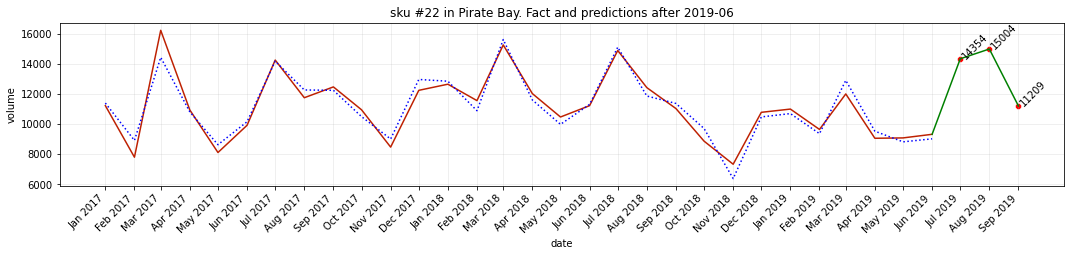


============sku #25============

ADF Statistic: 0.665880
p-value: 0.989132
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646

LinearRegression
SMAPE: 2.55


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  4863.034820
1 2019-08-01  4068.054726
2 2019-09-01  3111.691927


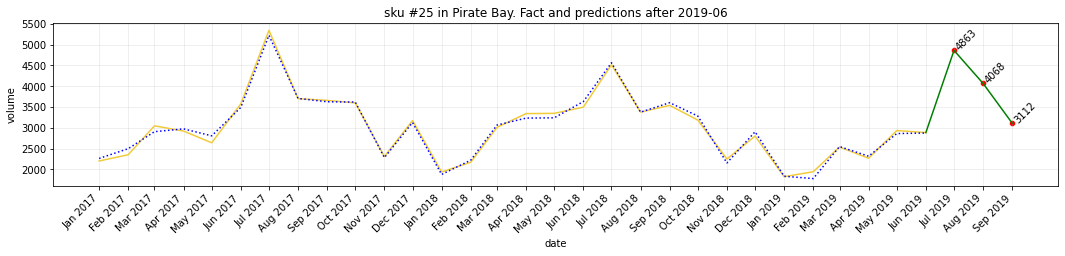


============sku #28============

ADF Statistic: -3.350634
p-value: 0.012761
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 4.21


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  7734.370729
1 2019-08-01  7422.027267
2 2019-09-01  4747.046244


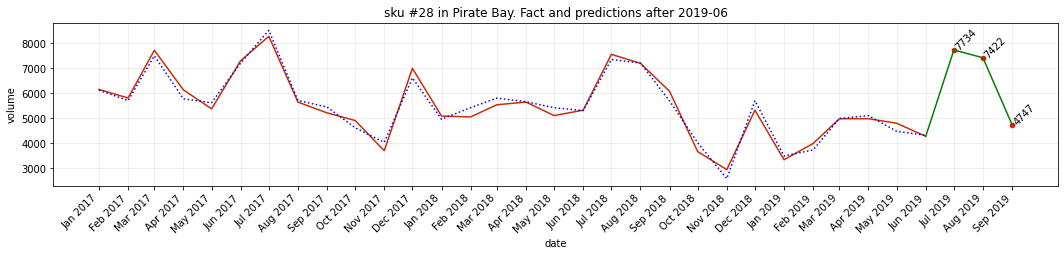


============sku #30============

ADF Statistic: 0.230216
p-value: 0.973906
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646

LinearRegression
SMAPE: 5.97


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  9435.271725
1 2019-08-01  5427.729384
2 2019-09-01  6924.007354


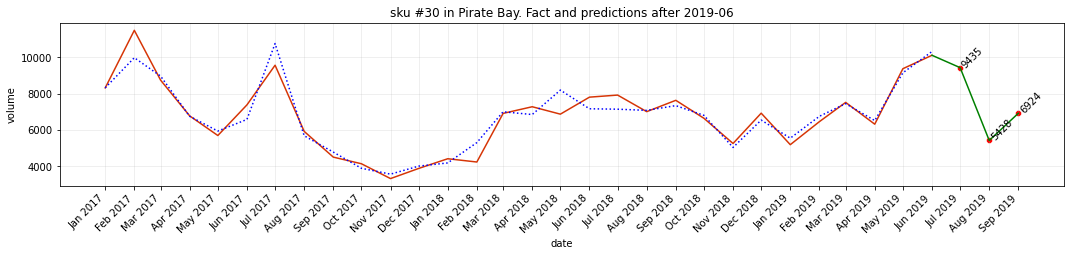


============sku #38============

ADF Statistic: -4.272786
p-value: 0.000495
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 4.81


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  1496.828588
1 2019-08-01  2385.368472
2 2019-09-01  1017.801907


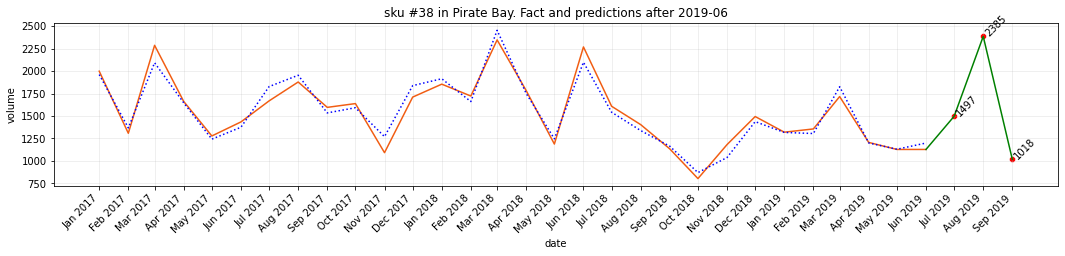


============sku #42============

ADF Statistic: -5.942502
p-value: 0.000000
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 7.31


Прогноз на 3 месяца:

        date      volume
0 2019-07-01  -16.757501
1 2019-08-01   87.241363
2 2019-09-01  109.710243


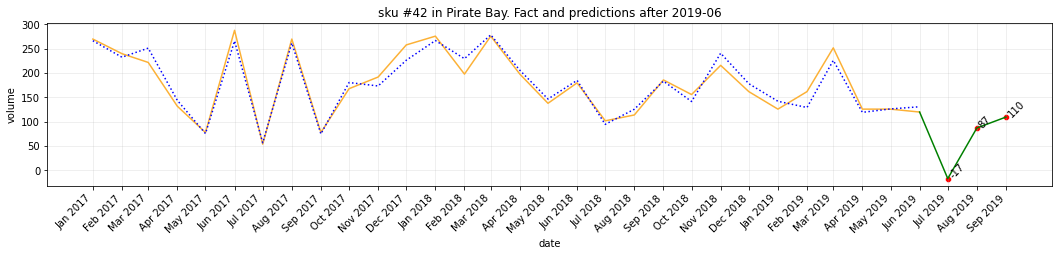


============sku #46============

ADF Statistic: -4.078161
p-value: 0.001052
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636

LinearRegression
SMAPE: 4.18


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  5754.742654
1 2019-08-01  3716.051412
2 2019-09-01  5379.532689


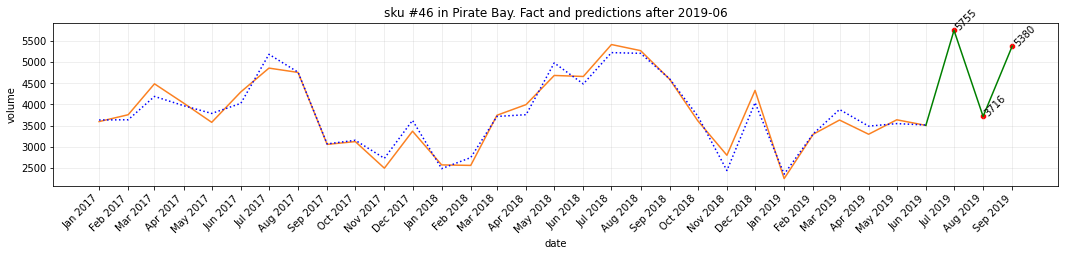


============sku #48============

ADF Statistic: -3.440047
p-value: 0.009667
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 3.96


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  8090.051065
1 2019-08-01  7888.316712
2 2019-09-01  5558.819247


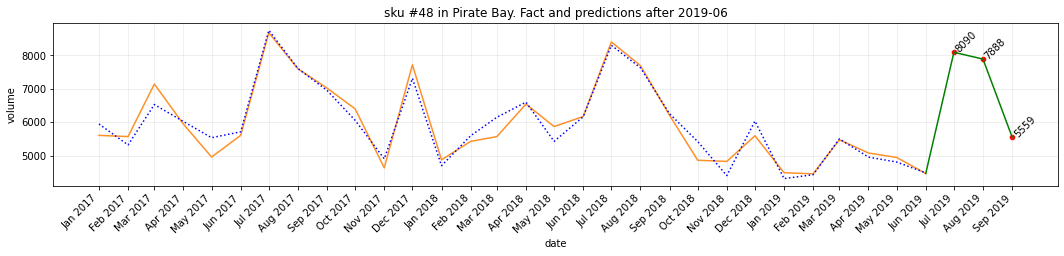


============sku #49============

ADF Statistic: -2.201699
p-value: 0.205630
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

LinearRegression
SMAPE: 14.07


Прогноз на 3 месяца:

        date       volume
0 2019-07-01   766.244937
1 2019-08-01  6066.725618
2 2019-09-01   368.107253


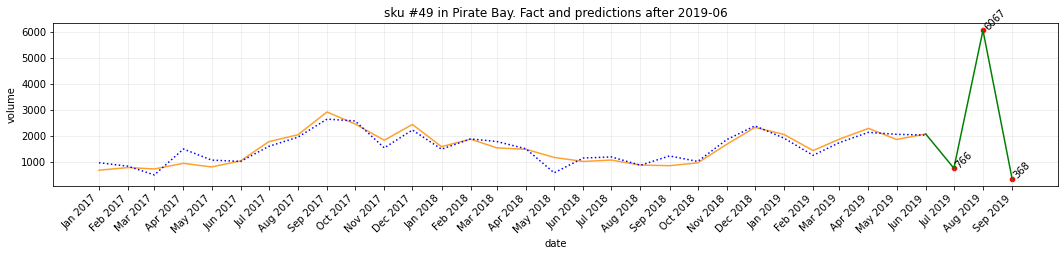


============sku #67============

ADF Statistic: 0.239601
p-value: 0.974397
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651

LinearRegression
SMAPE: 9.2


Прогноз на 3 месяца:

        date      volume
0 2019-07-01   95.258110
1 2019-08-01  628.398141
2 2019-09-01  586.016019


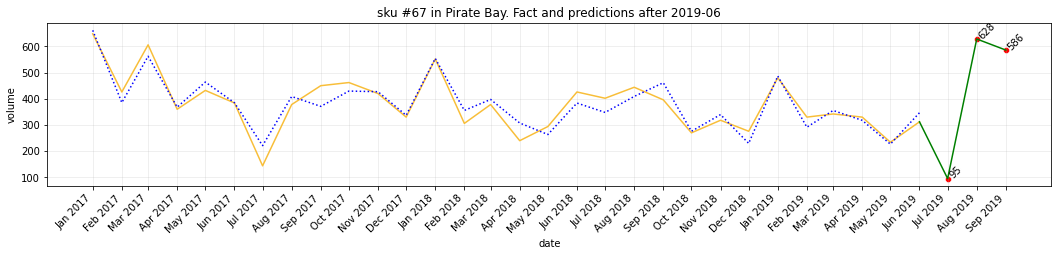


============sku #73============

ADF Statistic: -4.187915
p-value: 0.000691
Critical Values:
	1%: -3.770
	5%: -3.005
	10%: -2.643

LinearRegression
SMAPE: 4.27


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  2826.371404
1 2019-08-01  2605.655060
2 2019-09-01  2454.204874


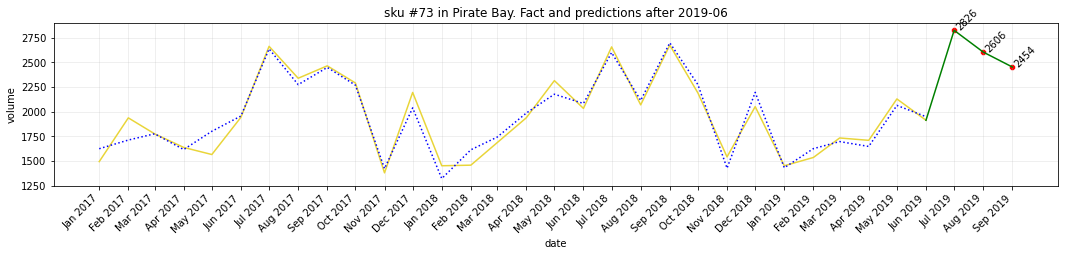


============sku #79============

ADF Statistic: -1.174808
p-value: 0.684338
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651

LinearRegression
SMAPE: 7.27


Прогноз на 3 месяца:

        date       volume
0 2019-07-01  1247.914771
1 2019-08-01  1435.974863
2 2019-09-01   632.746741


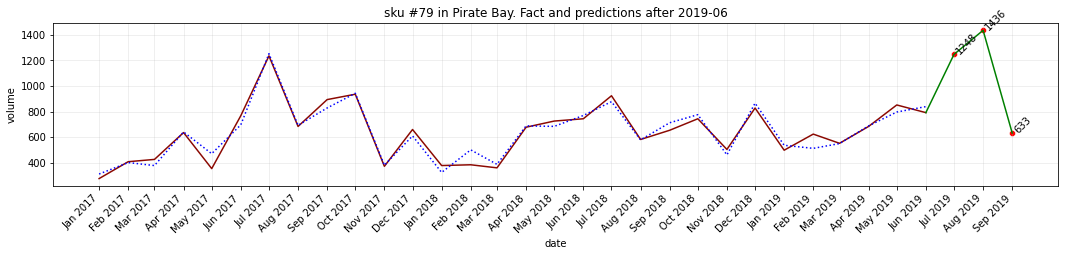






************== Location: Village(VL) ==************

Товары к прогнозу (0)
[]


In [403]:
sku_id_predicted = [] #сюда буду сохранять Ид товаров по которым уже предсказал продажи
max_num_date = len(df_merge['date'].unique())

for location in df_merge.location.unique():
    ira = location_dict[location]
    df_city_sku_on_date = df_merge[df_merge['location'] == location]\
                                  .pivot_table(index='date'
                                             , columns='sku_id'
                                             , values='volume') 
    #Выбираю товары у которых есть данные по продажам за каждый месяц (все 30 записей)
    city_sku_ids_all_volume = df_city_sku_on_date.notnull().sum()\
              .where(lambda v: v == max_num_date).dropna().index
    
    print('\n\n\n\n\n************== Location: {}({}) ==************'.format(location, ira))
    print('\nТовары к прогнозу ({})\n{}'.format(len(city_sku_ids_all_volume),
                                                city_sku_ids_all_volume.values))   
    for sku_id in city_sku_ids_all_volume:
        sku_id_predicted.append(sku_id)
        df_sku = pd.DataFrame()
        print('\n============{}============\n'.format(sku_id))

        #---Тренировочные данные----
        #Тренировочные данные по продажам товара в конкретном городе
        df_sku = df_merge[(df_merge['sku_id']== sku_id) \
                         & (df_merge['ira'] == ira)]\
                .sort_values(by='date')

        #Добавляю номер месяца
        df_sku['month_num'] = range(0, df_sku.shape[0])

        #Критерий на стационарность
        result = adfuller(df_sku['volume'].values)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

        #средний нормализованный сглаженный коэффициент продаж по месяцам
        _ = df_sku.groupby('month').sum()[['volume','item_per_bundle']]
        min_max_scaler = MinMaxScaler()
        _ = min_max_scaler.fit_transform(pd.DataFrame(_['volume'] 
                                                / _['item_per_bundle']))
        month_volume_coefs = {i+1: np.round(value[0],3) for (i, value) 
                              in enumerate(_)}
        df_sku['month_volume_coef'] = df_sku['month'].map(month_volume_coefs)

        #сглаженные коэффициенты продаж
        chain_growth = []
        chain_growth_rate = []

        for i, idx in enumerate(df_sku.index):
            cur_volume = df_sku.loc[idx]['volume']
            if 0 == i:
                previous = cur_volume
            chain_growth.append(cur_volume - previous)
            chain_growth_rate.append(cur_volume/previous)
            previous = cur_volume

        df_sku['chain_growth'] = chain_growth
        df_sku['chain_growth_rate'] = chain_growth_rate

        df_sku_coefs = df_sku.pivot_table(index='month'
                          , values=['chain_growth', 'chain_growth_rate']
                          , aggfunc={'mean'})

        chain_growth_coefs = {i+1: np.round(value,1) for (i, value) in enumerate(
                                    df_sku_coefs[df_sku_coefs.columns[0]].values)}
        chain_growth_rate_coefs = {i+1: np.round(value,4) for (i, value) in \
                                   enumerate(df_sku_coefs[df_sku_coefs.columns[1]]
                                             .values)}
        df_sku['chain_growth_rate_avg'] = df_sku['month']\
                                         .map(chain_growth_rate_coefs)
        df_sku['chain_growth_avg'] = df_sku['month']\
                                    .map(chain_growth_coefs)

        #---Данные для прогноза----
        # Датафремй для предсказания 7,8 и 9 месяца 2019
        df_sku_custs789 = pd.DataFrame({'year':[2019]*3
                                       , 'month':[7,8,9]
                                       , 'ira':[ira]*3
                                       , 'volume':[0]*3
                                        })

        #Столбец с датой
        df_sku_custs789['date'] = df_sku_custs789[['year','month']]\
                                        .apply(lambda r: '{}-{}'
                                        .format(r['year'], r['month']), axis=1)
        df_sku_custs789['date'] = pd.to_datetime(df_sku_custs789['date'])
        # Столбец с номером месяца относительно последнего по товару и городу
        month_amont_to_predict = 3
        month_nums_to_predict = range(df_sku['month_num'].max()+1
                                , df_sku['month_num'].max()+1
                                  +month_amont_to_predict)
        df_sku_custs789['month_num'] = month_nums_to_predict
        #Столбец коэффициент месячных продаж
        df_sku_custs789['month_volume_coef'] = df_sku_custs789['month']\
                                               .map(month_volume_coefs)
        #Столбцы сглаженные коэффициенты продаж
        df_sku_custs789['chain_growth_rate_avg'] = df_sku_custs789['month']\
                                                   .map(chain_growth_rate_coefs)
        df_sku_custs789['chain_growth_avg'] = df_sku_custs789['month']\
                                              .map(chain_growth_coefs)
        #Добавлю данные по потоку клиентов
        df_sku_custs789 = df_sku_custs789.join(df_custs_amount
                                                     , on=['ira','date'])

        #---Прогноз----
        col_names = ['other', 'Archer', 'Centaur','Demon', 'Dwarf', 'Elf'\
            ,'Angel','Gargoyle', 'Genie', 'Ghost', 'Giant','Goblin', 'Gremlin'\
            ,'Medusa', 'Minotaur', 'Monk', 'Orc', 'Pegasus','Pirate', 'Unicorn'\
            ,'chain_growth_avg', 'chain_growth_rate_avg', 'month_volume_coef']
        scaler = StandardScaler()
        X = scaler.fit_transform(df_sku[col_names])
        X_new = scaler.transform(df_sku_custs789[col_names])
        y = df_sku['volume']

        lr_fitted = LinearRegression().fit(X, y)
        y_pred_train = lr_fitted.predict(X)
        y_pred_new = lr_fitted.predict(X_new)
        df_sku_custs789['volume'] = y_pred_new  
        print('\nLinearRegression\nSMAPE: {}\n'.format(smape(y, y_pred_train)))
        #Объединяю фактические и предсказанные данные по продажам
        df_sku_pred =pd.DataFrame().append([
                             df_sku[['date','ira', 'volume']]
                           , df_sku_custs789[['date','ira'
                                            , 'volume']]])
        #Рисую график факта и прогноза
        plot_fact_predict(df_sku_pred, y_pred_train, sku_id, location)


### Цена (в работе...)

Новый столбец - выручка (выручка = продажи * цена)

In [ ]:
df_ac_sku79['proceeds'] = df_ac_sku79['volume'] * df_ac_sku79['price']

In [ ]:
fsize = (12, 3)
fig = plt.figure(figsize=fsize)
plt.grid(alpha=0.25)
sns.lineplot(data=df_ac_sku79, x='date', y='price');

До 2018-01 у нас нет цен по рядоу продуктов, восстанавливать их не вижу смысла т.к. данные уже устаревшие, буду работать с ценой начиная с 2018 года.

In [ ]:
# Новый столбец - отношение продаж текущего месяца к продажам в этом месяце в прошлом году
df_ac_sku79['month_growth'] = 100

In [ ]:
for year in [2019, 2018]:
    curr_year = df_ac_sku79[df_ac_sku79['year'] == year]
    last_year = df_ac_sku79[df_ac_sku79['year'] == year-1]
    for idx, row in curr_year.iterrows():
        df_ac_sku79.at[idx, 'month_growth'] = (row['volume'] / last_year[last_year['month'] == row['month']]['volume']) * 100

In [ ]:
data = df_ac_sku79[(df_ac_sku79['date'] >= '2018-01')\
                & (df_ac_sku79['date'] <= '2018-12')]\
     [['proceeds', 'price', 'month', 'sum_customers']]

sns.pairplot(data=data);

In [ ]:
data = df_ac_sku79[(df_ac_sku79['date'] >= '2019-01') \
                & (df_ac_sku79['date'] <= '2019-06')]\
     [['proceeds', 'price', 'month', 'sum_customers', 'month_growth']]

sns.pairplot(data=data);

In [ ]:
# Новый столбец - количество продаж на одного прибывшего в город клиента
df_ac_sku79['volume_per_customer'] = df_ac_sku79['volume'] / df_ac_sku79['sum_customers']

In [ ]:
data = df_ac_sku79[(df_ac_sku79['date'] >= '2018-01')].groupby('month').sum() \
     [['volume_per_customer', 'price', 'month_growth']]

sns.pairplot(data=data);

Спрогнозирую цену на отсутствующие значения и посмотрю на сколько этот параметр будет влиять на модельdf_ac_sku79

In [ ]:
#переверну данные
df_ac_sku79_rev = pd.DataFrame(columns=['price', 'volume', 'month_volume_coef'])

for idx in reversed(df_ac_sku79.index):
    df_ac_sku79_rev = df_ac_sku79_rev.append(df_ac_sku79.loc[idx, ['price', 'volume', 'month_volume_coef']])

In [ ]:
df_ac_sku79[['price', 'volume', 'month_volume_coef']].tail()

In [ ]:
df_ac_sku79_rev.head()

In [ ]:
df_ac_sku79_rev['volume_pow2'] = df_ac_sku79_rev['volume'].pow(2)
df_ac_sku79_rev['month_volume_coef_pow2'] = df_ac_sku79_rev['month_volume_coef'].pow(2)

In [ ]:
df_ac_sku79_rev[df_ac_sku79_rev['price'] > 0].corr()

In [ ]:
X_train = df_ac_sku79_rev[df_ac_sku79_rev['price'] > 0].drop('price', axis=1)
y_train = df_ac_sku79_rev[df_ac_sku79_rev['price'] > 0]['price']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
lr_fitted = LinearRegression().fit(X_train, y_train)
y_pred = lr_fitted.predict(df_ac_sku79_rev[df_ac_sku79_rev['price'] == 0].drop('price', axis=1))

In [ ]:
y_pred

In [ ]:
for i, idx in enumerate(df_ac_sku79_rev[df_ac_sku79_rev['price'] == 0].index):
    df_ac_sku79_rev.loc[idx]['price'] = y_pred[i]